In [1]:
# ======================================================================
# CLEAN & ORGANIZED IMPORTS
# ======================================================================

# --- Standard Library ---
import os
import re
import logging
import warnings
from pathlib import Path

# --- Data Handling ---
import numpy as np
import pandas as pd

# --- Visualization ---
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib.ticker import PercentFormatter
import seaborn as sns

# --- Statistics & Math ---
import statsmodels.api as sm
from scipy.special import expit
from scipy.stats import pearsonr, spearmanr, chi2_contingency

# --- Display ---
from IPython.display import display

# --- Preprocessing & Imputation ---
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    PowerTransformer, MinMaxScaler, RobustScaler,
    StandardScaler, OneHotEncoder, OrdinalEncoder
)

# --- Machine Learning Models & Tools ---
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

# --- Model Selection & Evaluation ---
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score, recall_score, precision_score

# --- Imbalanced Data Handling ---
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.pipeline import Pipeline as ImbPipeline

# --- Hyperparameter Optimization ---
import optuna

# --- Pandas Utilities ---
from pandas.api.types import CategoricalDtype


# ======================================================================
# CONFIGURATION
# ======================================================================

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Reduce logging noise
logging.getLogger('matplotlib').setLevel(logging.WARNING)
logging.getLogger('seaborn').setLevel(logging.WARNING)
optuna.logging.set_verbosity(optuna.logging.WARNING)

p:\projects\heart disease prediction\env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Project root (default fallback if environment variable not set)
PROJECT_ROOT = Path(os.environ.get('PROJECT_ROOT', '../../')).resolve()

# Raw data directory (use environment variable if available, otherwise use default)
DATA_RAW_DIR = Path(os.environ.get('DATA_RAW_DIR', PROJECT_ROOT / 'data/raw')).resolve()

# File path for the heart disease dataset
data_file = DATA_RAW_DIR / 'heart disease.parquet'

# Enhanced error handling with directory validation
if not DATA_RAW_DIR.exists():
    print(f"Error: Data directory not found: {DATA_RAW_DIR.resolve()}")
    print(f"Current working directory: {Path.cwd()}")
    print("Please check your project structure or set the DATA_RAW_DIR environment variable.")
    sys.exit(1)

# Check if file exists with detailed error message
if not data_file.is_file():
    print(f"Error: Heart disease dataset not found: {data_file.resolve()}")
    available_files = list(DATA_RAW_DIR.glob('*.parquet'))
    if available_files:
        print(f"Available parquet files in directory: {[f.name for f in available_files]}")
    else:
        print(f"No parquet files found in {DATA_RAW_DIR}")
    sys.exit(1)

# Load dataset with try-except for more robust error handling
try:
    df = pd.read_parquet(data_file)
    print(f"Successfully loaded dataset from: {data_file}")
except Exception as e:
    print(f"Error reading parquet file: {e}")
    sys.exit(1)

# Drop 'id' column if present
if 'id' in df.columns:
    df = df.drop(columns='id')
    print("Dropped 'id' column from dataset")

# Basic validation checks
print(f"Dataset shape: {df.shape}")
print(f"Columns: {', '.join(df.columns)}")
print(f"Missing values: {df.isna().sum().sum()}")

# Display first few rows of the dataset
print("\nFirst 5 rows of the dataset:")
print(df.head())

Successfully loaded dataset from: P:\projects\heart disease prediction\data\raw\heart disease.parquet
Dataset shape: (70000, 12)
Columns: age, gender, height, weight, ap_hi, ap_lo, cholesterol, gluc, smoke, alco, active, cardio
Missing values: 0

First 5 rows of the dataset:
     age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
0  18393       2     168    62.0    110     80            1     1      0   
1  20228       1     156    85.0    140     90            3     1      0   
2  18857       1     165    64.0    130     70            3     1      0   
3  17623       2     169    82.0    150    100            1     1      0   
4  17474       1     156    56.0    100     60            1     1      0   

   alco  active  cardio  
0     0       1       0  
1     0       1       1  
2     0       0       1  
3     0       1       1  
4     0       0       0  


In [3]:
# drop the duplicates records
df=df.drop_duplicates().reset_index(drop=True)
df.shape

(69976, 12)

In [4]:
# Show columns names
df.columns

Index(['age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol',
       'gluc', 'smoke', 'alco', 'active', 'cardio'],
      dtype='object')

In [5]:
# Robust column renaming with validation
column_mapping = {
    'age': 'Age',
    'gender': 'Sex',
    'height': 'Height',
    'weight': 'Weight',
    'ap_hi': 'Systolic_BP',
    'ap_lo': 'Diastolic_BP',
    'cholesterol': 'Cholesterol_Level',
    'gluc': 'Glucose_Level',
    'smoke': 'Smoking_Status',
    'alco': 'Alcohol_Intake',
    'active': 'Physical_Activity',
    'cardio': 'target'
}
df = df.rename(columns={k: v for k, v in column_mapping.items() if k in df.columns})
df.columns  # Show column names after renaming

Index(['Age', 'Sex', 'Height', 'Weight', 'Systolic_BP', 'Diastolic_BP',
       'Cholesterol_Level', 'Glucose_Level', 'Smoking_Status',
       'Alcohol_Intake', 'Physical_Activity', 'target'],
      dtype='object')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69976 entries, 0 to 69975
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Age                69976 non-null  int64  
 1   Sex                69976 non-null  int64  
 2   Height             69976 non-null  int64  
 3   Weight             69976 non-null  float64
 4   Systolic_BP        69976 non-null  int64  
 5   Diastolic_BP       69976 non-null  int64  
 6   Cholesterol_Level  69976 non-null  int64  
 7   Glucose_Level      69976 non-null  int64  
 8   Smoking_Status     69976 non-null  int64  
 9   Alcohol_Intake     69976 non-null  int64  
 10  Physical_Activity  69976 non-null  int64  
 11  target             69976 non-null  int64  
dtypes: float64(1), int64(11)
memory usage: 6.4 MB


In [7]:
categorical_cols = ['Sex','target','Cholesterol_Level','Glucose_Level','Smoking_Status',
                    'Alcohol_Intake', 'Physical_Activity']

float_cols = ['Height', 'Weight']

num_cols = ['Age','Systolic_BP', 'Diastolic_BP']

# Convert categorical columns
for col in categorical_cols:
    if col in df.columns:
        df[col] = df[col].astype('category')
        print(f"Converted {col} to category type")

# Convert float columns - handle missing values properly
for col in float_cols:
    if col in df.columns:
        # 'coerce' will turn any non-numeric values into NaN (missing)
        df[col] = pd.to_numeric(df[col], errors='coerce')
        # No need for astype(float) since to_numeric already returns float
        print(f"Converted {col} to float type")

# Convert integer columns - handle NaN values correctly
for col in num_cols:
    if col in df.columns:
        # First convert to numeric with coercion for invalid values
        df[col] = pd.to_numeric(df[col], errors='coerce')
        # Then convert to integer, but only for non-NaN values
        # This avoids the error when trying to convert NaN to int
        mask = df[col].notna()
        if mask.all():
            df[col] = df[col].astype(int)
        else:
            # Keep NaN values as is, convert only valid values to int
            df.loc[mask, col] = df.loc[mask, col].astype(int)
        print(f"Converted {col} to integer type (with NaN handling)")

# Display dataframe info
print("\nDataFrame Information:")
df.info()

Converted Sex to category type
Converted target to category type
Converted Cholesterol_Level to category type
Converted Glucose_Level to category type
Converted Smoking_Status to category type
Converted Alcohol_Intake to category type
Converted Physical_Activity to category type
Converted Height to float type
Converted Weight to float type
Converted Age to integer type (with NaN handling)
Converted Systolic_BP to integer type (with NaN handling)
Converted Diastolic_BP to integer type (with NaN handling)

DataFrame Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69976 entries, 0 to 69975
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   Age                69976 non-null  int32   
 1   Sex                69976 non-null  category
 2   Height             69976 non-null  int64   
 3   Weight             69976 non-null  float64 
 4   Systolic_BP        69976 non-null  int32   
 5   Diastolic_

In [8]:
df.describe()

,Age,Height,Weight,Systolic_BP,Diastolic_BP
count,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000
mean,19468.950126,164.359152,74.208519,128.820453,96.636261
std,2467.374620,8.211218,14.397211,154.037729,188.504581
min,10798.000000,55.000000,10.000000,-150.000000,-70.000000
25%,17664.000000,159.000000,65.000000,120.000000,80.000000
50%,19703.000000,165.000000,72.000000,120.000000,80.000000
75%,21327.000000,170.000000,82.000000,140.000000,90.000000
max,23713.000000,250.000000,200.000000,16020.000000,11000.000000


performing validation primarily by considering these specific, impossible values from your raw data summary:

* **For `Systolic_BP`:** The `min` of **-150** and the `max` of **16,020**.
* **For `Diastolic_BP`:** The `min` of **-70** and the `max` of **11,000**.
* **For `Height_mt`:** The `min` of **0.55**.
* **For `Weight`:** The `min` of **10**.

These values are physiologically impossible and represent clear data errors that must be corrected before any analysis can be done.

### Data Preprocessing: Clinical Range Validation and Correction

### BloodPressure cleaning

In [10]:
# ---------------------------
# Blood Pressure - Intelligent Cleaning
# ---------------------------
systolic_col, diastolic_col = 'Systolic_BP', 'Diastolic_BP'
if systolic_col in df.columns and diastolic_col in df.columns:
    
    print("\nBlood Pressure Cleaning:")
    print(f"Initial systolic range: {df[systolic_col].min():.0f} - {df[systolic_col].max():.0f}")
    print(f"Initial diastolic range: {df[diastolic_col].min():.0f} - {df[diastolic_col].max():.0f}")
    
    # Step 1: Fix obvious typos (4-digit values)
    # Diastolic typos (11000 → 110)
    diastolic_typo_mask = df[diastolic_col] >= 1000
    fixable_diastolic = diastolic_typo_mask & ((df[diastolic_col] / 10) >= 40) & ((df[diastolic_col] / 10) <= 180)
    df.loc[fixable_diastolic, diastolic_col] /= 10
    df.loc[diastolic_typo_mask & ~fixable_diastolic, diastolic_col] = np.nan
    print(f"  Fixed {fixable_diastolic.sum()} diastolic typos (÷10)")
    
    # Systolic typos (16020 → 160)
    systolic_typo_mask = df[systolic_col] >= 1000
    fixable_systolic = systolic_typo_mask & ((df[systolic_col] / 10) >= 70) & ((df[systolic_col] / 10) <= 250)
    df.loc[fixable_systolic, systolic_col] /= 10
    df.loc[systolic_typo_mask & ~fixable_systolic, systolic_col] = np.nan
    print(f"  Fixed {fixable_systolic.sum()} systolic typos (÷10)")
    
    # Step 2: Swap inverted values BEFORE range validation
    swap_mask = (df[systolic_col] < df[diastolic_col]) & df[systolic_col].notna() & df[diastolic_col].notna()
    if swap_mask.any():
        df.loc[swap_mask, [systolic_col, diastolic_col]] = \
            df.loc[swap_mask, [diastolic_col, systolic_col]].values
        print(f"  Swapped {swap_mask.sum()} inverted BP pairs")
    
    # Step 3: Ensure numeric dtype for BP values
    df[systolic_col] = pd.to_numeric(df[systolic_col], errors='coerce')
    df[diastolic_col] = pd.to_numeric(df[diastolic_col], errors='coerce')
    
    # Step 4: Nullify negative BP values (clearly errors)
    negative_sys = df[systolic_col] < 0
    df.loc[negative_sys, systolic_col] = np.nan
    print(f"  Systolic < 0: {negative_sys.sum()} nullified")
    
    negative_dia = df[diastolic_col] < 0
    df.loc[negative_dia, diastolic_col] = np.nan
    print(f"  Diastolic < 0: {negative_dia.sum()} nullified")
    
    # Step 5: Intelligent systolic validation
    # Extremely low systolic (< 70) - likely measurement error
    very_low_systolic = df[systolic_col] < 70
    df.loc[very_low_systolic, systolic_col] = np.nan
    print(f"  Nullified {very_low_systolic.sum()} extremely low systolic (< 70)")
    
    # Extremely high systolic (> 250) - likely error, hypertensive crisis max ~240
    very_high_systolic = df[systolic_col] > 250
    df.loc[very_high_systolic, systolic_col] = np.nan
    print(f"  Nullified {very_high_systolic.sum()} extremely high systolic (> 250)")
    
    # Step 6: Intelligent diastolic validation
    # Extremely low diastolic (< 40)
    very_low_diastolic = df[diastolic_col] < 40
    df.loc[very_low_diastolic, diastolic_col] = np.nan
    print(f"  Nullified {very_low_diastolic.sum()} extremely low diastolic (< 40)")
    
    # Extremely high diastolic (> 150) - diastolic rarely exceeds 140
    very_high_diastolic = df[diastolic_col] > 150
    df.loc[very_high_diastolic, diastolic_col] = np.nan
    print(f"  Nullified {very_high_diastolic.sum()} extremely high diastolic (> 150)")
    
    # Step 7: Check for physiologically impossible combinations
    # Pulse pressure (systolic - diastolic) should be 20-100 typically
    pulse_pressure = df[systolic_col] - df[diastolic_col]
    
    # Pulse pressure < 10 is medically concerning/likely error
    low_pp_mask = (pulse_pressure < 10) & df[systolic_col].notna() & df[diastolic_col].notna()
    df.loc[low_pp_mask, [systolic_col, diastolic_col]] = np.nan
    print(f"  Nullified {low_pp_mask.sum()} BP pairs with pulse pressure < 10")
    
    # Pulse pressure > 120 is very rare (except in elderly with stiff arteries)
    high_pp_mask = (pulse_pressure > 120) & df[systolic_col].notna() & df[diastolic_col].notna()
    df.loc[high_pp_mask, [systolic_col, diastolic_col]] = np.nan
    print(f"  Nullified {high_pp_mask.sum()} BP pairs with pulse pressure > 120")
    
    # Step 8: Final BP statistics
    print(f"\nAfter BP cleaning:")
    print(f"  Systolic range: {df[systolic_col].min():.0f} - {df[systolic_col].max():.0f}")
    print(f"  Diastolic range: {df[diastolic_col].min():.0f} - {df[diastolic_col].max():.0f}")
    print(f"  Systolic nulls: {df[systolic_col].isna().sum()}")
    print(f"  Diastolic nulls: {df[diastolic_col].isna().sum()}")


Blood Pressure Cleaning:
Initial systolic range: -150 - 16020
Initial diastolic range: -70 - 11000
  Fixed 894 diastolic typos (÷10)
  Fixed 15 systolic typos (÷10)
  Swapped 315 inverted BP pairs
  Systolic < 0: 0 nullified
  Diastolic < 0: 8 nullified
  Nullified 14 extremely low systolic (< 70)
  Nullified 48 extremely high systolic (> 250)
  Nullified 233 extremely low diastolic (< 40)
  Nullified 8 extremely high diastolic (> 150)
  Nullified 5 BP pairs with pulse pressure < 10
  Nullified 11 BP pairs with pulse pressure > 120

After BP cleaning:
  Systolic range: 70 - 240
  Diastolic range: 40 - 150
  Systolic nulls: 87
  Diastolic nulls: 292


### Height and weight cleaning

In [ ]:
# ---------------------------
# Height and Weight - Intelligent Cleaning
# ---------------------------
height_col, weight_col = 'Height', 'Weight'
if height_col in df.columns and weight_col in df.columns:
    
    print("\nHeight and Weight Cleaning:")
    print(f"Initial height range: {df[height_col].min():.1f} - {df[height_col].max():.1f} cm")
    print(f"Initial weight range: {df[weight_col].min():.1f} - {df[weight_col].max():.1f} kg")
    
    # Step 1: Ensure numeric dtype for values
    df[height_col] = pd.to_numeric(df[height_col], errors='coerce')
    df[weight_col] = pd.to_numeric(df[weight_col], errors='coerce')
    
    # Step 2: Fix height values with incorrect magnitude
    # Some height values might be in meters instead of cm or vice versa
    
    # Heights that are too small (likely in meters instead of cm)
    small_height_mask = (df[height_col] > 0) & (df[height_col] < 3)
    df.loc[small_height_mask, height_col] *= 100
    print(f"  Converted {small_height_mask.sum()} heights from meters to cm (× 100)")
    
    # Heights that are too large (likely in mm instead of cm)
    large_height_mask = df[height_col] > 300
    df.loc[large_height_mask, height_col] /= 10
    print(f"  Fixed {large_height_mask.sum()} extremely large heights (÷ 10)")
    
    # Step 3: Fix weight values with incorrect magnitude
    # Weights that are too large (likely typos with extra digits)
    large_weight_mask = df[weight_col] > 500
    fixable_weight = large_weight_mask & ((df[weight_col] / 10) >= 30) & ((df[weight_col] / 10) <= 250)
    df.loc[fixable_weight, weight_col] /= 10
    df.loc[large_weight_mask & ~fixable_weight, weight_col] = np.nan
    print(f"  Fixed {fixable_weight.sum()} extremely large weights (÷ 10)")
    
    # Step 4: Nullify negative height/weight values (clearly errors)
    negative_height = df[height_col] <= 0
    df.loc[negative_height, height_col] = np.nan
    print(f"  Height ≤ 0: {negative_height.sum()} nullified")
    
    negative_weight = df[weight_col] <= 0
    df.loc[negative_weight, weight_col] = np.nan
    print(f"  Weight ≤ 0: {negative_weight.sum()} nullified")
    
    # Step 5: Handle physiologically implausible heights for adults
    # Extremely short (< 130 cm or 4'3")
    very_short_mask = (df[height_col] < 130) & (df[height_col] > 0)
    df.loc[very_short_mask, height_col] = np.nan
    print(f"  Nullified {very_short_mask.sum()} extremely short heights (< 130 cm)")
    
    # Extremely tall (> 230 cm or 7'7")
    very_tall_mask = df[height_col] > 230
    df.loc[very_tall_mask, height_col] = np.nan
    print(f"  Nullified {very_tall_mask.sum()} extremely tall heights (> 230 cm)")
    
    # Step 6: Handle physiologically implausible weights for adults
    # Extremely light (< 30 kg or 66 lbs)
    very_light_mask = (df[weight_col] < 30) & (df[weight_col] > 0)
    df.loc[very_light_mask, weight_col] = np.nan
    print(f"  Nullified {very_light_mask.sum()} extremely low weights (< 30 kg)")
    
    # Extremely heavy (> 300 kg or 660 lbs) 
    very_heavy_mask = df[weight_col] > 300
    df.loc[very_heavy_mask, weight_col] = np.nan
    print(f"  Nullified {very_heavy_mask.sum()} extremely high weights (> 300 kg)")
    
    # Step 7: Check for physiologically implausible BMI combinations
    plausible_mask = df[height_col].notna() & df[weight_col].notna()
    if plausible_mask.any():
        bmi = df.loc[plausible_mask, weight_col] / ((df.loc[plausible_mask, height_col] / 100) ** 2)
        
        # BMI < 12 is severely, life-threateningly underweight
        low_bmi_mask = (bmi < 12) & plausible_mask
        df.loc[low_bmi_mask, [height_col, weight_col]] = np.nan
        print(f"  Nullified {low_bmi_mask.sum()} height/weight pairs with BMI < 12")
        
        # BMI > 70 is extremely rare
        high_bmi_mask = (bmi > 70) & plausible_mask
        df.loc[high_bmi_mask, [height_col, weight_col]] = np.nan
        print(f"  Nullified {high_bmi_mask.sum()} height/weight pairs with BMI > 70")
    
    # Step 8: Final statistics
    print(f"\nAfter Height/Weight cleaning:")
    height_valid = df[height_col].notna()
    weight_valid = df[weight_col].notna()
    
    if height_valid.any():
        print(f"  Height range: {df.loc[height_valid, height_col].min():.1f} - {df.loc[height_valid, height_col].max():.1f} cm")
    else:
        print("  No valid height values remain")
    
    if weight_valid.any():
        print(f"  Weight range: {df.loc[weight_valid, weight_col].min():.1f} - {df.loc[weight_valid, weight_col].max():.1f} kg")
    else:
        print("  No valid weight values remain")
    
    print(f"  Height nulls: {df[height_col].isna().sum()} ({df[height_col].isna().mean()*100:.1f}%)")
    print(f"  Weight nulls: {df[weight_col].isna().sum()} ({df[weight_col].isna().mean()*100:.1f}%)")
    
    # Print available records for BMI calculation
    both_valid = height_valid & weight_valid
    print(f"  Records with both height and weight valid: {both_valid.sum()} ({both_valid.mean()*100:.1f}%)")

### Feature Engineering

In [11]:
# Convert Age from days to years with improved handling
if 'Age' in df.columns:
    # Use 365.25 days to account for leap years
    # Convert to numeric first to handle any non-numeric values
    df['Age'] = pd.to_numeric(df['Age'], errors='coerce')
    
    # Convert from days to years, round to nearest integer
    df['Age'] = (df['Age'] / 365.25).round().astype(int)
    
    # Rename column to reflect the new unit
    df.rename(columns={'Age': 'Age_Years'}, inplace=True)
    
    print(f"Converted Age from days to years ({df['Age_Years'].notna().sum()} values processed)")

In [12]:
# ---------------------------
# BMI calculation with validation
# ---------------------------
if 'Height' in df.columns and 'Weight' in df.columns:
    # Check for valid measurements first
    height_valid = (df['Height'] > 0) & df['Height'].notna()
    weight_valid = (df['Weight'] > 0) & df['Weight'].notna()
    both_valid = height_valid & weight_valid
    
    # Calculate BMI only where both measurements are valid
    df['BMI'] = np.nan  # Initialize with NaN
    
    # Avoid division by zero and use proper formula: weight(kg) / height(m)²
    df.loc[both_valid, 'BMI'] = df.loc[both_valid, 'Weight'] / ((df.loc[both_valid, 'Height'] / 100) ** 2)
    
    # Log the results
    print(f"\nBMI Calculation:")
    print(f"  Records with valid height and weight: {both_valid.sum()} ({both_valid.mean()*100:.1f}%)")
    print(f"  BMI range: {df['BMI'].min():.1f} - {df['BMI'].max():.1f}")
    print(f"  BMI missing: {df['BMI'].isna().sum()} ({df['BMI'].isna().mean()*100:.1f}%)")
    
    # Drop original measurements after calculation
    df = df.drop(columns=['Height', 'Weight'], axis=1)
    print("  Dropped Height and Weight columns after BMI calculation")
else:
    print("Error: Height or Weight columns not found. Cannot calculate BMI.")


BMI Calculation:
  Records with valid height and weight: 69976 (100.0%)
  BMI range: 3.5 - 298.7
  BMI missing: 0 (0.0%)
  Dropped Height and Weight columns after BMI calculation


BP Classification Summary:
Normal       9564
Elevated     3112
Stage 1     39847
Stage 2+    17113
Name: BP_label, dtype: int64

Total records: 69976
Records with BP classification: 69636


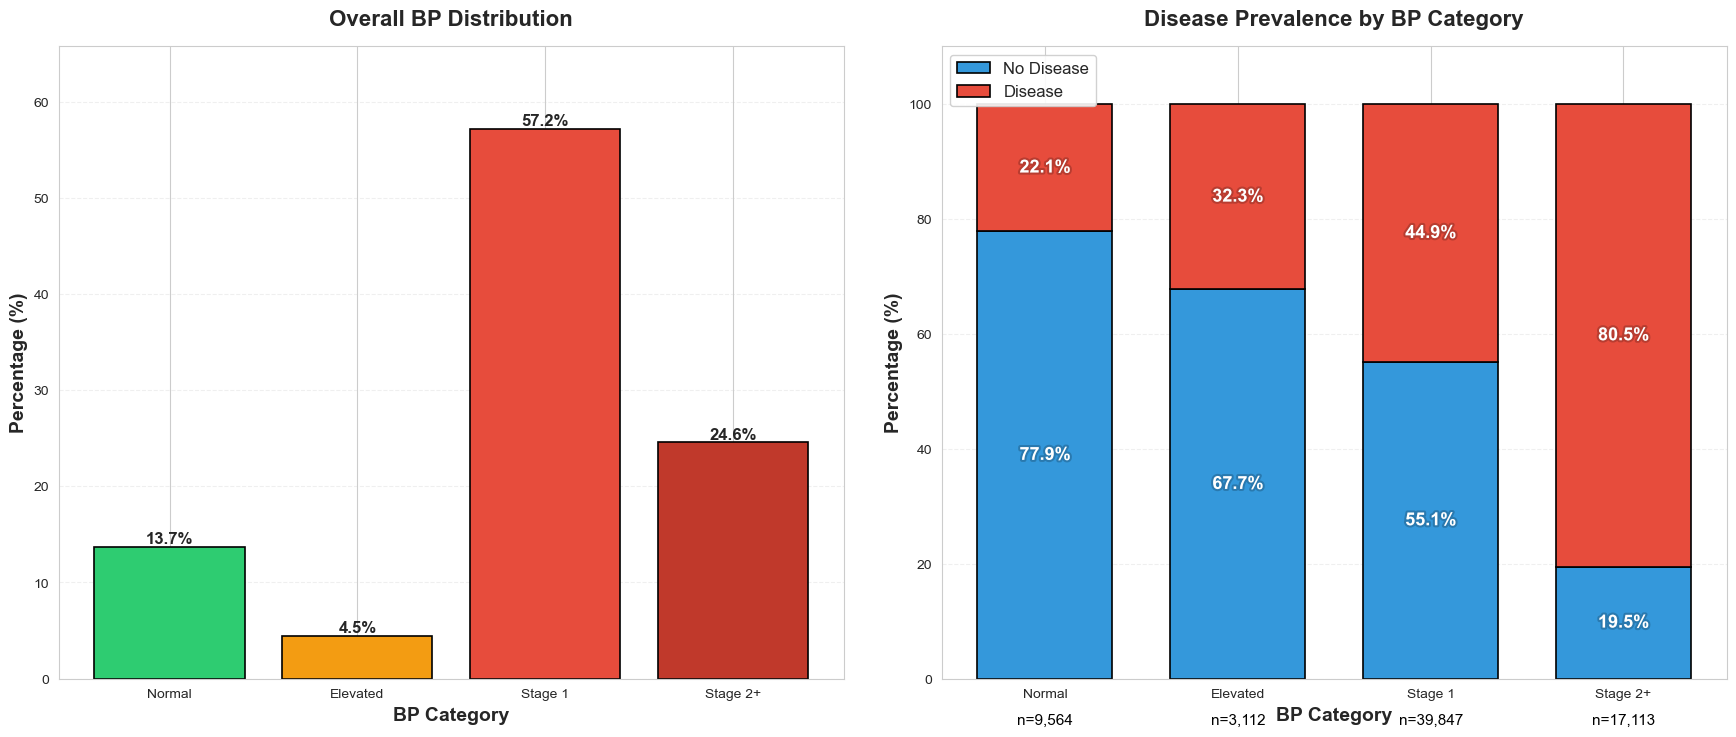

In [15]:
import matplotlib.patheffects

def classify_bp(row):
    try:
        # First check if values exist and can be converted to float
        if pd.isna(row['Systolic_BP']) or pd.isna(row['Diastolic_BP']):
            return np.nan
            
        sbp = float(row['Systolic_BP'])
        dbp = float(row['Diastolic_BP'])
        
        # Then check for negative values
        if sbp < 0 or dbp < 0:
            return np.nan
    except Exception:
        return np.nan

    if sbp < 120 and dbp < 80:
        return 1  # Normal
    elif 120 <= sbp <= 129 and dbp < 80:
        return 2  # Elevated
    elif (130 <= sbp <= 139) or (80 <= dbp <= 89):
        return 3  # Hypertension Stage 1
    elif sbp >= 140 or dbp >= 90: 
        return 4  # Hypertension Stage 2+
    else:
        return np.nan

# Define BP labels and order
bp_labels = {
    1: 'Normal',
    2: 'Elevated',
    3: 'Stage 1',
    4: 'Stage 2+'
}
bp_order = list(bp_labels.values())

# Apply classification
df['BP_level'] = df.apply(classify_bp, axis=1)
df['BP_label'] = df['BP_level'].map(bp_labels)
df['BP_label'] = pd.Categorical(df['BP_label'], categories=bp_order, ordered=True)
df['BP_level'] = df['BP_level'].astype('category')
df['target_name'] = df['target'].map({0: 'No Disease', 1: 'Disease'})

# Print classification summary
print("BP Classification Summary:")
print(df['BP_label'].value_counts().sort_index())
print(f"\nTotal records: {len(df)}")
print(f"Records with BP classification: {df['BP_label'].notna().sum()}")

# --- Create figure with subplots (1 row, 2 columns) ---
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
sns.set_style("whitegrid")

# --- LEFT PLOT: Overall BP Distribution (without target label) ---
plot_data_overall = df['BP_label'].value_counts(normalize=True).reindex(bp_order).reset_index()
plot_data_overall.columns = ['BP_label', 'percent']
plot_data_overall['percent'] *= 100

colors_overall = ['#2ecc71', '#f39c12', '#e74c3c', '#c0392b']

bars_left = axes[0].bar(
    plot_data_overall['BP_label'],
    plot_data_overall['percent'],
    color=colors_overall,
    edgecolor='black',
    linewidth=1.2
)

axes[0].set_title('Overall BP Distribution', fontsize=16, weight='bold', pad=15)
axes[0].set_xlabel('BP Category', fontsize=14, weight='bold')
axes[0].set_ylabel('Percentage (%)', fontsize=14, weight='bold')
axes[0].set_ylim(0, max(plot_data_overall['percent']) * 1.15)
axes[0].grid(axis='y', alpha=0.3, linestyle='--')

# Add percentage labels on the bars
for bar in bars_left:
    height = bar.get_height()
    axes[0].text(
        bar.get_x() + bar.get_width() / 2., height,
        f'{height:.1f}%', ha='center', va='bottom',
        fontsize=12, weight='bold'
    )

# --- RIGHT PLOT: Stacked Bar Chart by Target ---
plot_data_stacked = (
    df.dropna(subset=['BP_label', 'target_name'])
      .groupby(['BP_label', 'target_name'])
      .size()
      .unstack(fill_value=0)
)
plot_data_pct = plot_data_stacked.div(plot_data_stacked.sum(axis=1), axis=0) * 100

x = np.arange(len(bp_order))
width = 0.7  # Slightly wider bars

color_no_disease = '#3498db'
color_disease = '#e74c3c'

no_disease_pct = [plot_data_pct.loc[cat, 'No Disease'] if cat in plot_data_pct.index else 0 for cat in bp_order]
disease_pct = [plot_data_pct.loc[cat, 'Disease'] if cat in plot_data_pct.index else 0 for cat in bp_order]

bar1 = axes[1].bar(x, no_disease_pct, width, label='No Disease', 
                  color=color_no_disease, edgecolor='black', linewidth=1.2)
bar2 = axes[1].bar(x, disease_pct, width, bottom=no_disease_pct, label='Disease', 
                  color=color_disease, edgecolor='black', linewidth=1.2)

axes[1].set_title('Disease Prevalence by BP Category', fontsize=16, weight='bold', pad=15)
axes[1].set_xlabel('BP Category', fontsize=14, weight='bold')
axes[1].set_ylabel('Percentage (%)', fontsize=14, weight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(bp_order)
axes[1].set_ylim(0, 110)  # Increased to make room for labels
axes[1].legend(loc='upper left', fontsize=12, framealpha=0.9)
axes[1].grid(axis='y', alpha=0.3, linestyle='--')

# Improved label formatting for better readability
for i, (bp_cat, no_dis_val, dis_val) in enumerate(zip(bp_order, no_disease_pct, disease_pct)):
    # No disease labels (blue bars) - always show percentage
    axes[1].text(
        i, no_dis_val / 2, f'{no_dis_val:.1f}%',
        ha='center', va='center', fontsize=13,
        weight='bold', color='white',
        path_effects=[
            matplotlib.patheffects.withStroke(linewidth=3, foreground='black', alpha=0.2)
        ]
    )
    
    # Disease labels (red bars) - always show percentage
    axes[1].text(
        i, no_dis_val + (dis_val / 2), f'{dis_val:.1f}%',
        ha='center', va='center', fontsize=13,
        weight='bold', color='white',
        path_effects=[
            matplotlib.patheffects.withStroke(linewidth=3, foreground='black', alpha=0.2)
        ]
    )

# Add category counts as x-axis labels with totals
category_counts = df['BP_label'].value_counts().reindex(bp_order)
for i, (bp_cat, count) in enumerate(category_counts.items()):
    axes[1].text(
        i, -6, f'n={count:,}',
        ha='center', va='top',
        fontsize=11, color='black'
    )

plt.tight_layout(pad=3.0)
plt.show()

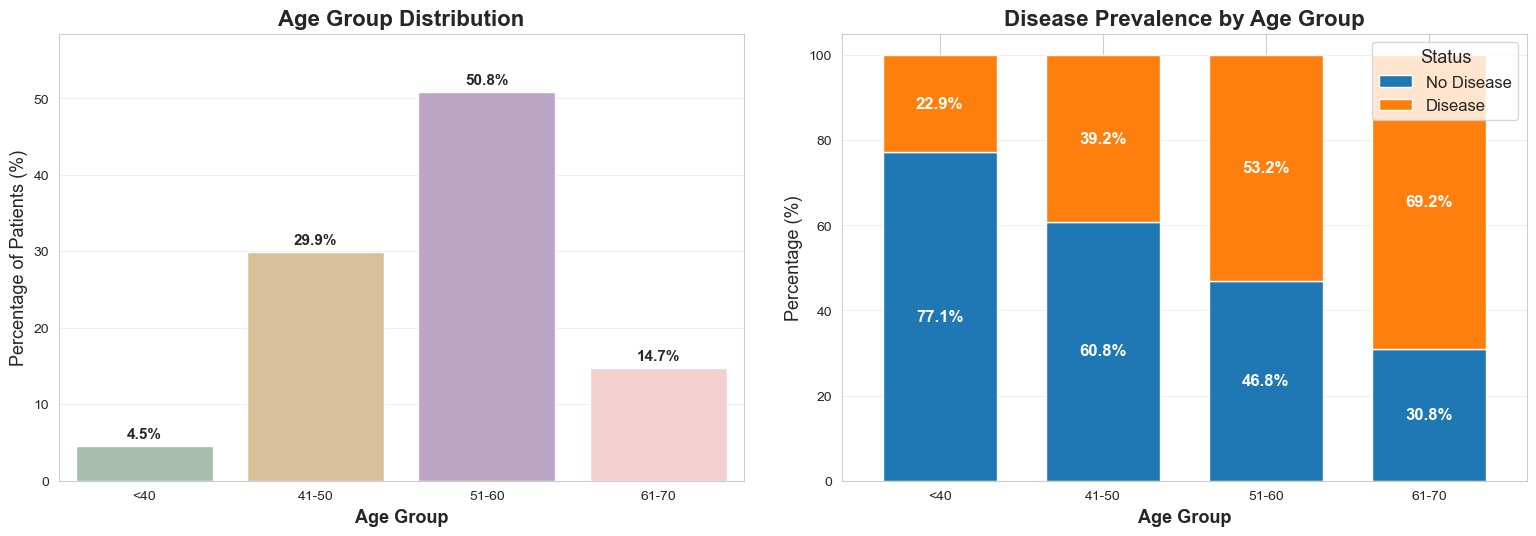

In [17]:
AGE_BINS = [0, 40, 50, 60, 70, 100]
AGE_LABELS = ['<40', '41-50', '51-60', '61-70', '>70']

if 'Age_Years' in df.columns:
    # Remove invalid ages
    valid_mask = df['Age_Years'].between(AGE_BINS[0], AGE_BINS[-1])
    df = df[valid_mask].copy()

    # Create Age_Group
    df['Age_Group'] = pd.cut(df['Age_Years'], bins=AGE_BINS, labels=AGE_LABELS, 
                            right=True, include_lowest=True)
    
    # Map target to human-readable name
    df['target_name'] = df['target'].map({0: 'No Disease', 1: 'Disease'})

    # Only keep present age groups for plotting
    present_labels = df['Age_Group'].cat.categories[df['Age_Group'].value_counts().sort_index() > 0].tolist()

    # --- Create figure with subplots ---
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    sns.set_style("whitegrid")
    
    # --- Color palettes ---
    left_palette = ['#a3c1ad', '#e2c290', '#bfa0c9', '#f7cac9', '#7b9acc']
    right_palette = {'No Disease': '#1f77b4', 'Disease': '#ff7f0e'}

    # --- LEFT PLOT: Overall Age Distribution ---
    # Get counts and percentages
    age_counts = df['Age_Group'].value_counts().reindex(present_labels)
    plot_data_overall = df['Age_Group'].value_counts(normalize=True).reindex(present_labels).reset_index()
    plot_data_overall.columns = ['Age_Group', 'percent']
    plot_data_overall['percent'] *= 100

    # Create bar plot
    bars_left = sns.barplot(
        data=plot_data_overall,
        x='Age_Group', y='percent',
        order=present_labels,
        ax=axes[0],
        palette=left_palette
    )
    
    # Add percentage labels only (removed count labels)
    for i, p in enumerate(axes[0].patches):
        height = p.get_height()
        axes[0].text(
            p.get_x() + p.get_width()/2., 
            height + 1, 
            f'{height:.1f}%', 
            ha='center', fontsize=11, fontweight='bold'
        )

    # Customize first plot
    axes[0].set_title('Age Group Distribution', fontsize=16, fontweight='bold')
    axes[0].set_xlabel('Age Group', fontsize=13, fontweight='bold')
    axes[0].set_ylabel('Percentage of Patients (%)', fontsize=13)
    axes[0].grid(axis='y', alpha=0.3)
    axes[0].set_ylim(0, max(plot_data_overall['percent']) * 1.15)  # Add headroom for labels

    # --- RIGHT PLOT: Disease Risk by Age Group ---
    # Get crosstab of age group vs. disease status
    disease_by_age = pd.crosstab(
        df['Age_Group'], 
        df['target_name'],
        normalize='index'
    ) * 100
    
    # Ensure all age groups are included
    disease_by_age = disease_by_age.reindex(present_labels)
    
    # Plot stacked bars
    disease_by_age.plot(
        kind='bar',
        stacked=True,
        ax=axes[1],
        color=right_palette,
        width=0.7
    )
    
    # Add percentage labels
    prev_heights = np.zeros(len(disease_by_age))
    for i, col in enumerate(disease_by_age.columns):
        for j, (idx, val) in enumerate(disease_by_age[col].items()):
            # Skip very small segments
            if val < 3:
                continue
                
            # Calculate label position
            height = prev_heights[j] + val/2
            axes[1].text(
                j, height, f'{val:.1f}%', 
                ha='center', va='center', fontsize=12, 
                color='white', fontweight='bold'
            )
            prev_heights[j] += val

    # Customize second plot
    axes[1].set_title('Disease Prevalence by Age Group', fontsize=16, fontweight='bold')
    axes[1].set_xlabel('Age Group', fontsize=13, fontweight='bold')
    axes[1].set_ylabel('Percentage (%)', fontsize=13)
    axes[1].grid(axis='y', alpha=0.3)
    axes[1].set_ylim(0, 105)  # Leave space for labels
    axes[1].set_xticklabels(present_labels, rotation=0)
    axes[1].legend(title='Status', fontsize=12, title_fontsize=13)

    plt.tight_layout(pad=3)
    plt.show()

    # Clean up target_name if we need to
    if 'target_name' in df.columns:
        df = df.drop(['target_name'], axis=1, errors='ignore')

# Clean up variables
del AGE_BINS, AGE_LABELS
if 'valid_mask' in locals(): del valid_mask
if 'present_labels' in locals(): del present_labels
if 'plot_data_overall' in locals(): del plot_data_overall

### **Observations:**

* **Patient Population**
The study is mostly focused on middle-aged people. **Over half of all patients are in their 50s**.

* **Disease Risk by Age**
Age is a massive risk factor. The link is very clear: the older you get, the higher the risk of disease.

* **Key Insight**
While the largest group of patients is in their 50s, the **highest risk of disease** is found in the oldest group (`61-70`). The chance of having the disease **triples** from the youngest group (23%) to the oldest group (69%).

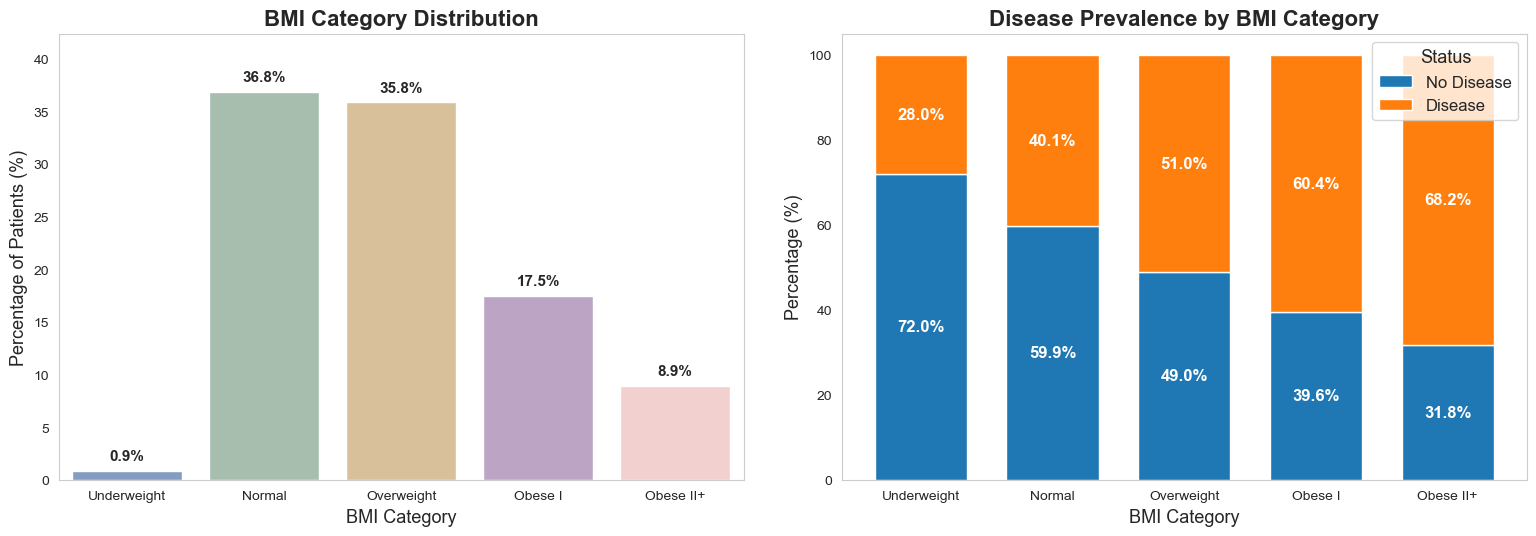

Plot created with 69976 BMI data points


In [18]:
# ---------------------------
# BMI Categorization and Barplot with/without Target
# ---------------------------
BMI_BINS = [0, 18.5, 25, 30, 35, float('inf')]
BMI_LABELS = ['Underweight', 'Normal', 'Overweight', 'Obese I', 'Obese II+']

# Check if BMI column exists and has data
if 'BMI' in df.columns and df['BMI'].notna().any():
    # Create BMI_Category
    df['BMI_Category'] = pd.cut(df['BMI'], bins=BMI_BINS, labels=BMI_LABELS, right=False)
    
    # Map target for right plot only
    df['target_name'] = df['target'].map({0: 'No Disease', 1: 'Disease'})
    
    # --- Subplots ---
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    sns.set_style("whitegrid")
    left_palette = ['#7b9acc', '#a3c1ad', '#e2c290', '#bfa0c9', '#f7cac9']  # Soft, non-blue/orange colors
    right_palette = {'No Disease': '#1f77b4', 'Disease': '#ff7f0e'}

    # --- LEFT PLOT: Overall distribution (no target label, different colors) ---
    # Get category counts and percentages
    bmi_counts = df['BMI_Category'].value_counts()
    plot_data_overall = df['BMI_Category'].value_counts(normalize=True).reindex(BMI_LABELS).reset_index()
    plot_data_overall.columns = ['BMI_Category', 'percent']
    plot_data_overall['percent'] *= 100

    # Create bar plot
    bars_left = sns.barplot(
        data=plot_data_overall,
        x='BMI_Category', y='percent',
        order=BMI_LABELS,
        ax=axes[0],
        palette=left_palette
    )
    
    # Add percentage labels
    for i, p in enumerate(axes[0].patches):
        height = p.get_height()
        axes[0].text(
            p.get_x() + p.get_width()/2., 
            height + 1, 
            f'{height:.1f}%', 
            ha='center', fontsize=11, fontweight='bold'
        )

    # Customize first plot
    axes[0].set_title('BMI Category Distribution', fontsize=16, fontweight='bold')
    axes[0].set_xlabel('BMI Category', fontsize=13)
    axes[0].set_ylabel('Percentage of Patients (%)', fontsize=13)
    axes[0].grid(False)
    axes[0].set_xticklabels(BMI_LABELS, rotation=0)
    axes[0].set_ylim(0, max(plot_data_overall['percent']) * 1.15)  # Add headroom for labels

    # --- RIGHT PLOT: Distribution by Target (target label, blue/orange) ---
    # Get crosstab of BMI category vs. disease status
    disease_by_bmi = pd.crosstab(
        df['BMI_Category'], 
        df['target_name'],
        normalize='index'
    ) * 100
    
    # Ensure all BMI categories are included
    disease_by_bmi = disease_by_bmi.reindex(BMI_LABELS)
    
    # Plot stacked bars
    disease_by_bmi.plot(
        kind='bar',
        stacked=True,
        ax=axes[1],
        color=right_palette,
        width=0.7
    )
    
    # Add percentage labels
    prev_heights = np.zeros(len(disease_by_bmi))
    for i, col in enumerate(disease_by_bmi.columns):
        for j, (idx, val) in enumerate(disease_by_bmi[col].items()):
            # Skip very small segments
            if val < 3:
                continue
                
            # Calculate label position
            height = prev_heights[j] + val/2
            axes[1].text(
                j, height, f'{val:.1f}%', 
                ha='center', va='center', fontsize=12, 
                color='white', fontweight='bold'
            )
            prev_heights[j] += val

    # Customize second plot
    axes[1].set_title('Disease Prevalence by BMI Category', fontsize=16, fontweight='bold')
    axes[1].set_xlabel('BMI Category', fontsize=13)
    axes[1].set_ylabel('Percentage (%)', fontsize=13)
    axes[1].grid(False)
    axes[1].set_ylim(0, 105)  # Leave space for labels
    axes[1].set_xticklabels(BMI_LABELS, rotation=0)
    axes[1].legend(title='Status', fontsize=12, title_fontsize=13)

    plt.tight_layout(pad=3)
    plt.show()
    
    print(f"Plot created with {df['BMI_Category'].notna().sum()} BMI data points")

    # --- Cleanup ---
    df.drop(['target_name'], axis=1, inplace=True, errors='ignore')
else:
    if 'BMI' not in df.columns:
        print("Error: 'BMI' column not found in the dataframe")
    else:
        print(f"Error: 'BMI' column exists but contains no valid data (all NaN)")

# Cleanup variables
del BMI_BINS, BMI_LABELS

### **Observations:**
Most of the patients in this study fall into the **'Normal'** or **'Overweight'** BMI groups, which are almost equal in size. Very few people in this group are underweight.

**Disease Risk by BMI**
Higher BMI is a **major risk factor**. The trend is very clear: as the BMI category increases, the chance of having the disease gets progressively higher.

**Key Insight**
The risk of disease climbs steadily from one category to the next. The chance of having the disease is lowest for 'Underweight' people (27.5%) and highest for the most obese group (**68.4%**).

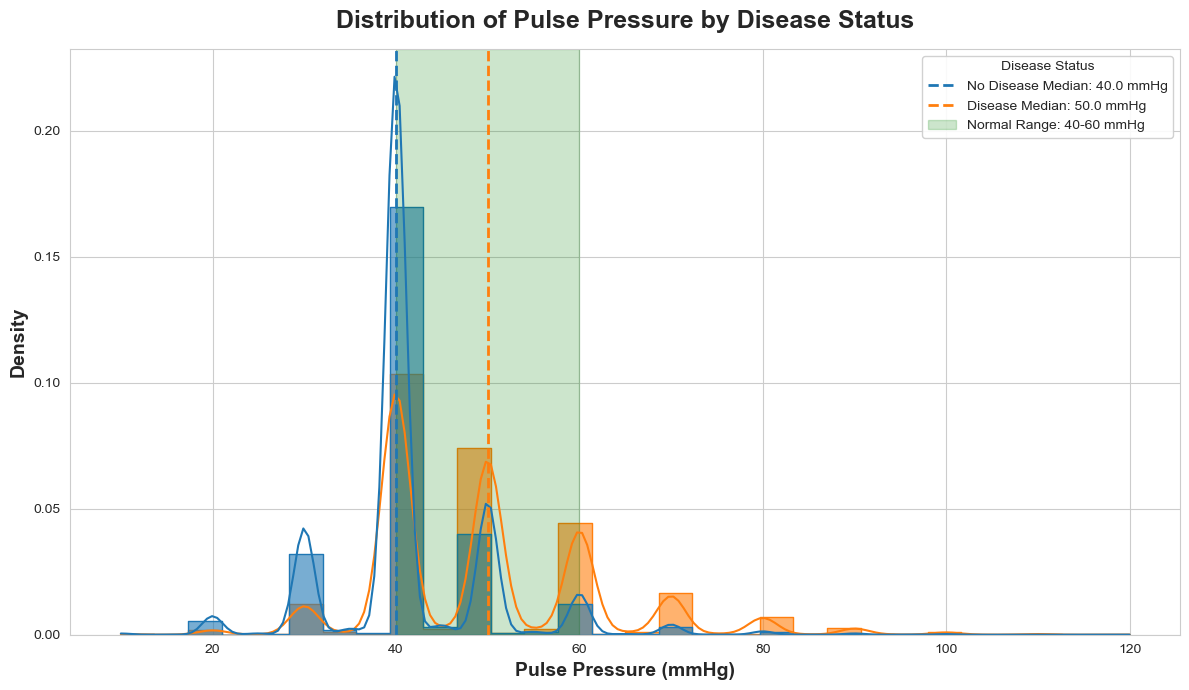

In [ ]:
# Feature engineering - Calculate Pulse Pressure
df['Pulse_Pressure'] = df['Systolic_BP'] - df['Diastolic_BP']

# Ensure target_name is defined for plotting
if 'target_name' not in df.columns:
    df['target_name'] = df['target'].map({0: 'No Disease', 1: 'Disease'})

# Define TARGET_PALETTE if not already defined
TARGET_PALETTE = {'No Disease': '#1f77b4', 'Disease': '#ff7f0e'}

# Create figure with improved styling
plt.figure(figsize=(12, 7))
sns.set_style('whitegrid')

# Plot distribution with both histogram and density curve
ax = sns.histplot(
    data=df, 
    x='Pulse_Pressure', 
    hue='target_name',
    bins=30,
    kde=True,  # Add density curves
    stat='density',  # Use density instead of count for better comparison
    alpha=0.6,  # Make bars semi-transparent
    palette=TARGET_PALETTE,
    element='step',  # Use step-style histograms for cleaner look
    common_norm=False  # Separate normalization for better group comparison
)

# Add vertical lines for group medians
for target, color in TARGET_PALETTE.items():
    median_val = df[df['target_name'] == target]['Pulse_Pressure'].median()
    plt.axvline(x=median_val, color=color, linestyle='--', linewidth=2, 
                label=f'{target} Median: {median_val:.1f} mmHg')

# Add normal range shading but with a label for the legend
plt.axvspan(40, 60, alpha=0.2, color='green', label='Normal Range: 40-60 mmHg')

# Create legend with all elements
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles=handles, 
           labels=labels,
           title='Disease Status',
           loc='upper right',
           frameon=True,
           framealpha=0.9)

# Enhance plot styling
plt.title('Distribution of Pulse Pressure by Disease Status', fontsize=18, weight='bold', pad=15)
plt.xlabel('Pulse Pressure (mmHg)', fontsize=14, weight='bold')
plt.ylabel('Density', fontsize=14, weight='bold')
plt.tight_layout()
plt.show()

In [21]:
# Check missing % per column
missing_pct = df.isna().mean() * 100
missing_pct

Age_Years            0.000000
Sex                  0.000000
Systolic_BP          0.124328
Diastolic_BP         0.417286
Cholesterol_Level    0.000000
Glucose_Level        0.000000
Smoking_Status       0.000000
Alcohol_Intake       0.000000
Physical_Activity    0.000000
target               0.000000
BMI                  0.000000
BP_level             0.485881
BP_label             0.485881
Age_Group            0.000000
BMI_Category         0.000000
Pulse_Pressure       0.485881
target_name          0.000000
dtype: float64

# Exploratory Data Analysis

### Numerical Analysis

[INFO] Using output directory: P:\projects\heart disease prediction\reports\visualizations\univariate analysis\numerical analysis


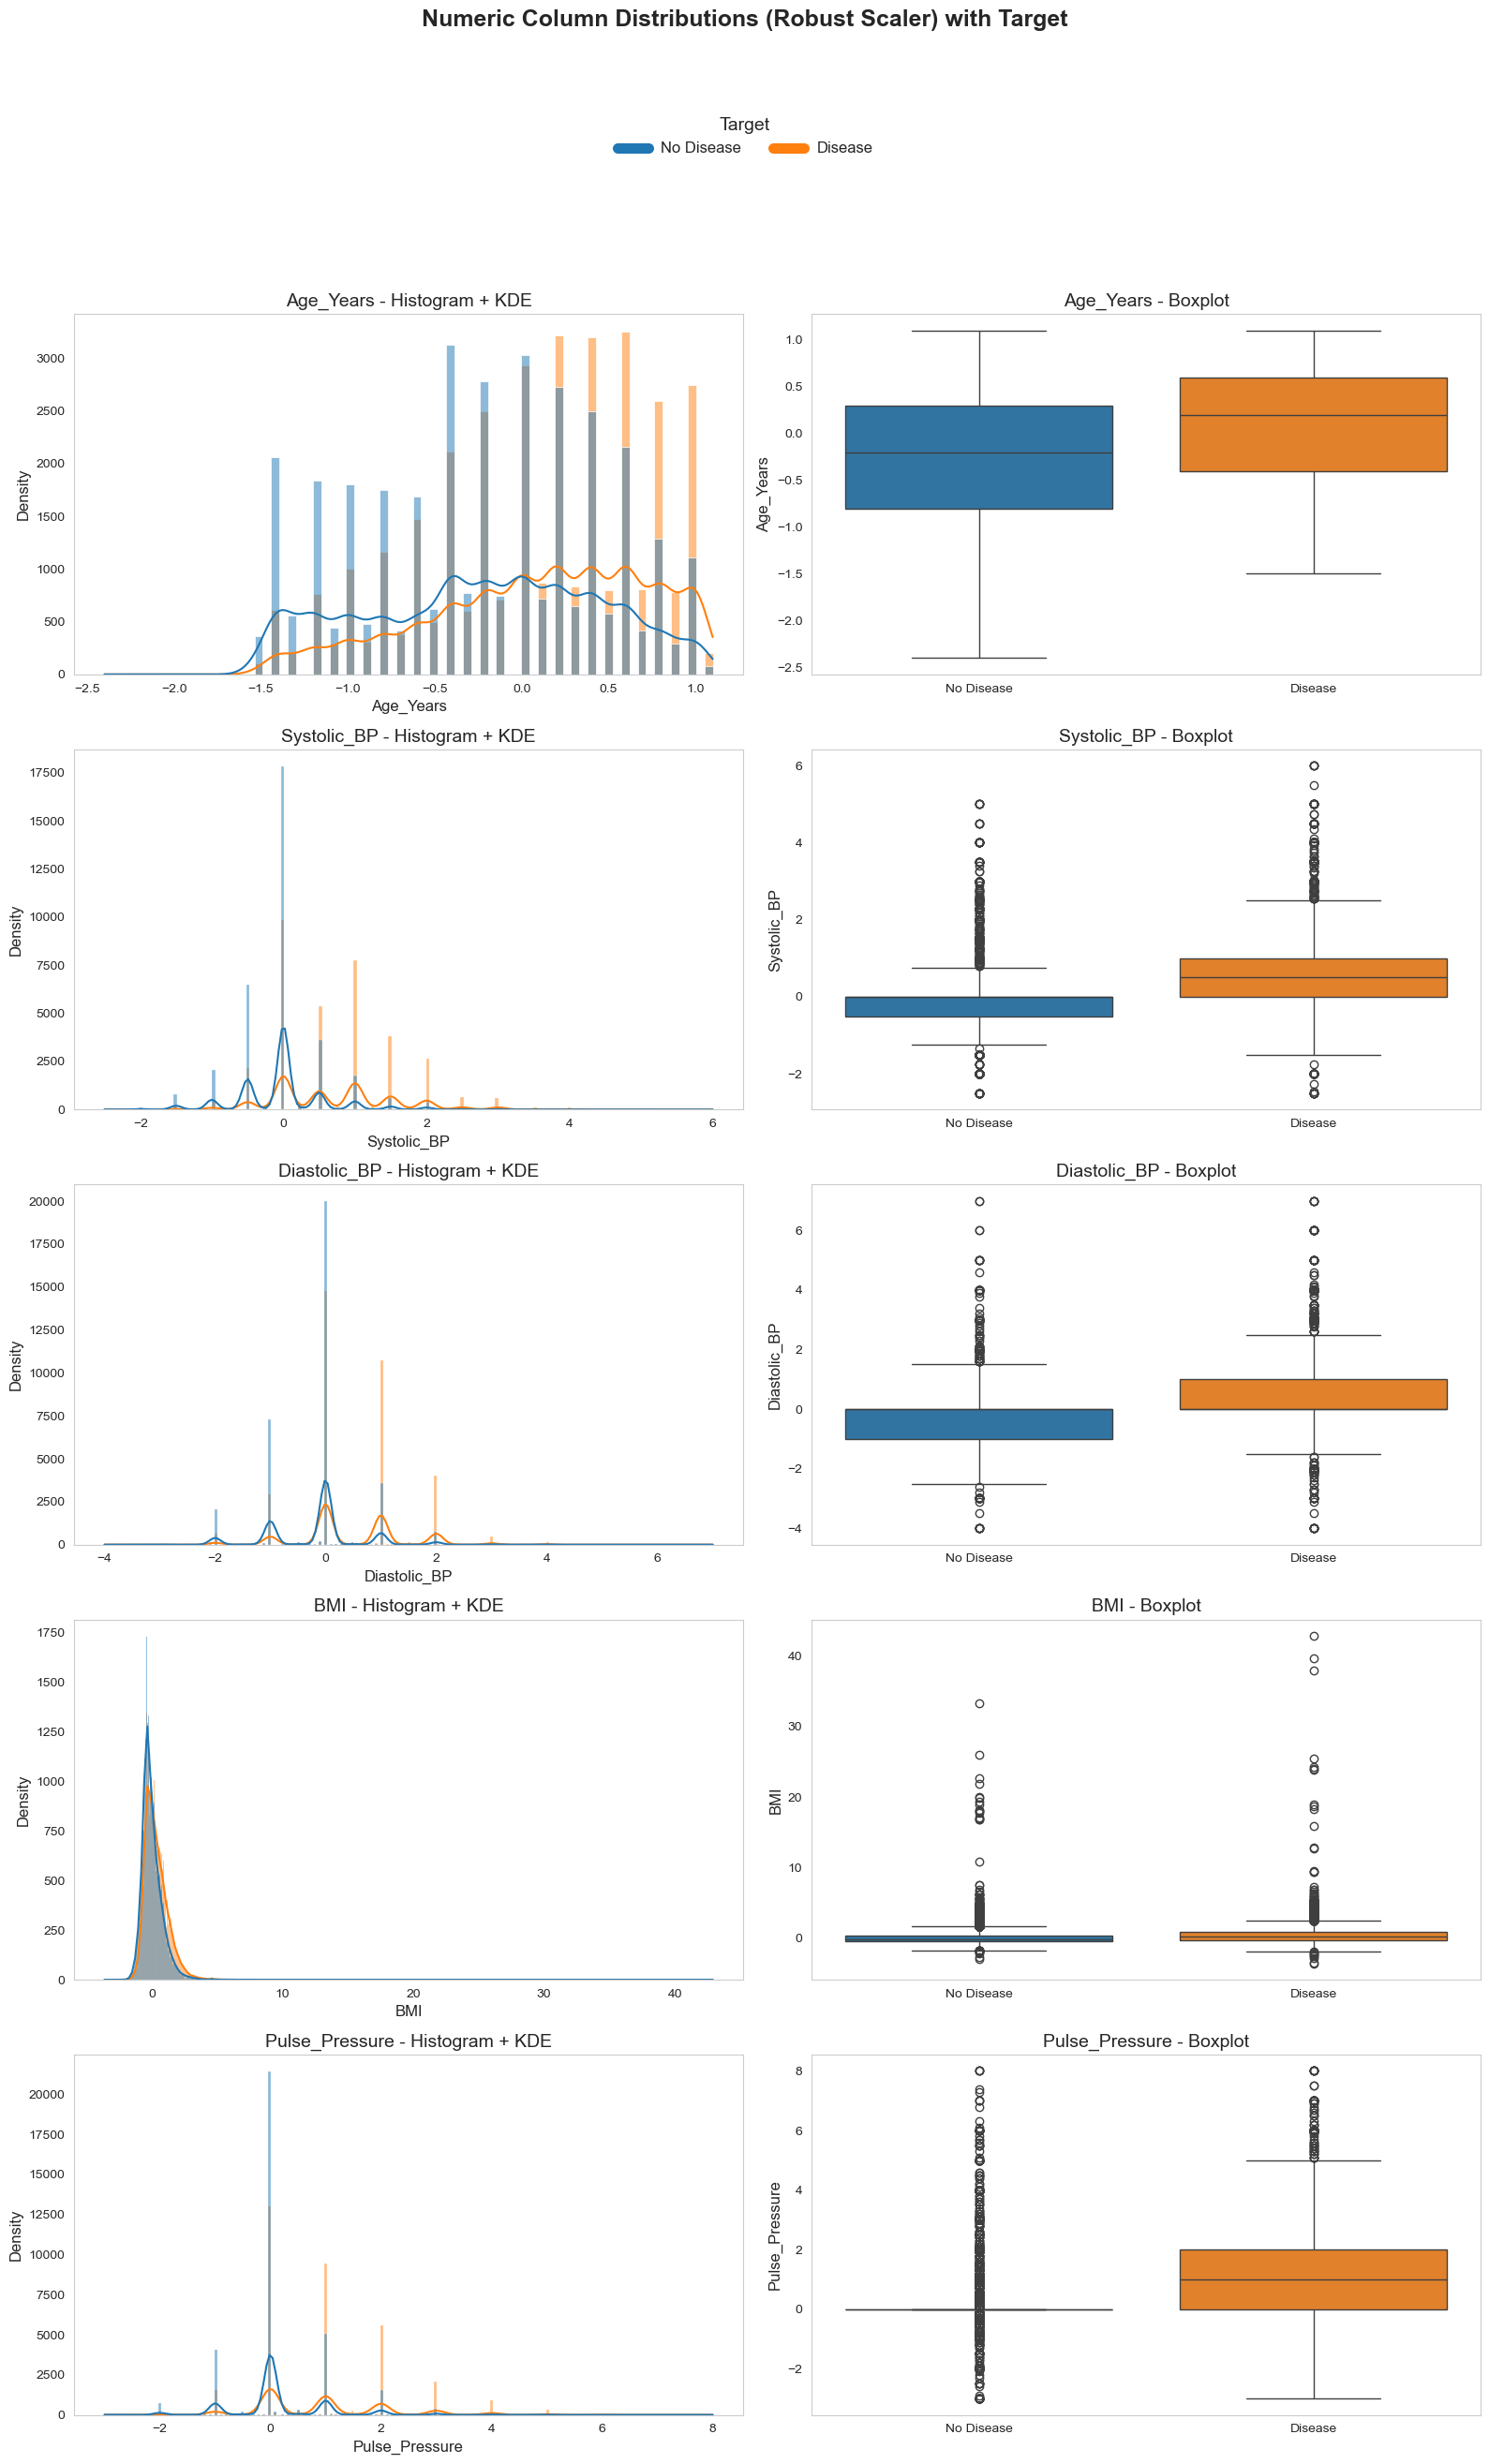

[SUCCESS] Plot saved to: P:\projects\heart disease prediction\reports\visualizations\univariate analysis\numerical analysis\01_Numeric_Columns_Distributions_RobustScaler.png


In [23]:
# ---------------------------
# Columns to scale
# ---------------------------
numeric_cols = ['Age_Years', 'Systolic_BP', 'Diastolic_BP', 'BMI', 'Pulse_Pressure']

# ---------------------------
# Target mapping
# ---------------------------
if 'target_name' not in df.columns and 'target' in df.columns:
    df['target_name'] = df['target'].map({0: 'No Disease', 1: 'Disease'})

TARGET_PALETTE = {'No Disease': '#1f77b4', 'Disease': '#ff7f0e'}

# ---------------------------
# Create a copy to avoid modifying original data
# ---------------------------
df_scaled = df.copy()

# Apply RobustScaler on copied data
scaler = RobustScaler()
df_scaled[numeric_cols] = scaler.fit_transform(df[numeric_cols])

# ---------------------------
# Figure layout: 2 columns per row
# ---------------------------
n_rows = len(numeric_cols)
fig, axes = plt.subplots(n_rows, 2, figsize=(16, 5 * n_rows), squeeze=False)

# Main title
fig.suptitle(
    'Numeric Column Distributions (Robust Scaler) with Target',
    fontsize=18, weight='bold', y=1.05
)

# ---------------------------
# Plotting
# ---------------------------
for i, col in enumerate(numeric_cols):
    data_plot = pd.DataFrame({'Value': df_scaled[col], 'target_name': df_scaled['target_name']})

    # --- Left: Histogram + KDE ---
    sns.histplot(
        data=data_plot, x='Value', hue='target_name', palette=TARGET_PALETTE,
        kde=True, ax=axes[i, 0], legend=False
    )
    axes[i, 0].set_title(f'{col} - Histogram + KDE', fontsize=14)
    axes[i, 0].set_xlabel(col, fontsize=12)
    axes[i, 0].set_ylabel('Density', fontsize=12)
    axes[i, 0].tick_params(axis='both', labelsize=10)
    axes[i, 0].grid(False)

    # --- Right: Boxplot ---
    sns.boxplot(
        data=data_plot, x='target_name', y='Value',
        palette=TARGET_PALETTE, ax=axes[i, 1], dodge=False, showfliers=True
    )
    axes[i, 1].set_title(f'{col} - Boxplot', fontsize=14)
    axes[i, 1].set_xlabel('')
    axes[i, 1].set_ylabel(col, fontsize=12)
    axes[i, 1].tick_params(axis='both', labelsize=10)
    axes[i, 1].grid(False)
    axes[i, 1].set_xticklabels(list(TARGET_PALETTE.keys()))

# ---------------------------
# Single horizontal legend below title
# ---------------------------
handles = [Line2D([0], [0], color=TARGET_PALETTE[name], lw=8, label=name) for name in TARGET_PALETTE]
fig.legend(
    handles=handles, labels=list(TARGET_PALETTE.keys()), title='Target',
    title_fontsize=14, fontsize=12, loc='upper center', bbox_to_anchor=(0.5, 1.01),
    ncol=len(TARGET_PALETTE), frameon=False
)

plt.tight_layout(rect=(0, 0, 1, 0.95))

# ---------------------------
# Save figure outside src, with proper error handling
# ---------------------------
try:
    PROJECT_ROOT = Path.cwd().parent.parent.resolve()  # Two levels up from src
    PLOT_DIR = PROJECT_ROOT / 'reports' / 'visualizations' / 'univariate analysis' / 'numerical analysis'

    # Create directory structure if needed
    PLOT_DIR.mkdir(parents=True, exist_ok=True)
    print(f"[INFO] Using output directory: {PLOT_DIR.resolve()}")

    img_path = PLOT_DIR / '01_Numeric_Columns_Distributions_RobustScaler.png'

    # Remove previous file if exists
    if img_path.exists():
        img_path.unlink()
        print(f"[INFO] Removed existing file: {img_path.name}")

    plt.savefig(img_path, bbox_inches='tight', dpi=150)
    plt.show()
    print(f"[SUCCESS] Plot saved to: {img_path.resolve()}")
    
except Exception as e:
    print(f"[ERROR] Failed to save plot: {str(e)}")
    plt.show()  # Still show the plot even if saving fails

***Observations:***

* ***Age is a Major Factor:*** The charts clearly show that patients with the disease are older.

* ***Blood Pressure is a Strong Sign:*** All blood pressure readings (Systolic, Diastolic, and Pulse Pressure) are noticeably higher in the group with the disease.

* ***BMI Shows a Connection:*** Higher BMI is linked to the disease, but the difference between the groups is less dramatic than it is for age and blood pressure.

***Main Takeaway:*** While all the metrics are important, age and high blood pressure are the strongest and most obvious indicators of the disease in these graphs.

[INFO] Using output directory: P:\projects\heart disease prediction\reports\visualizations\univariate analysis\numerical analysis
[SUCCESS] Plot saved to: P:\projects\heart disease prediction\reports\visualizations\univariate analysis\numerical analysis\02_Pairwise_Relationships_of_Numeric_Features.png


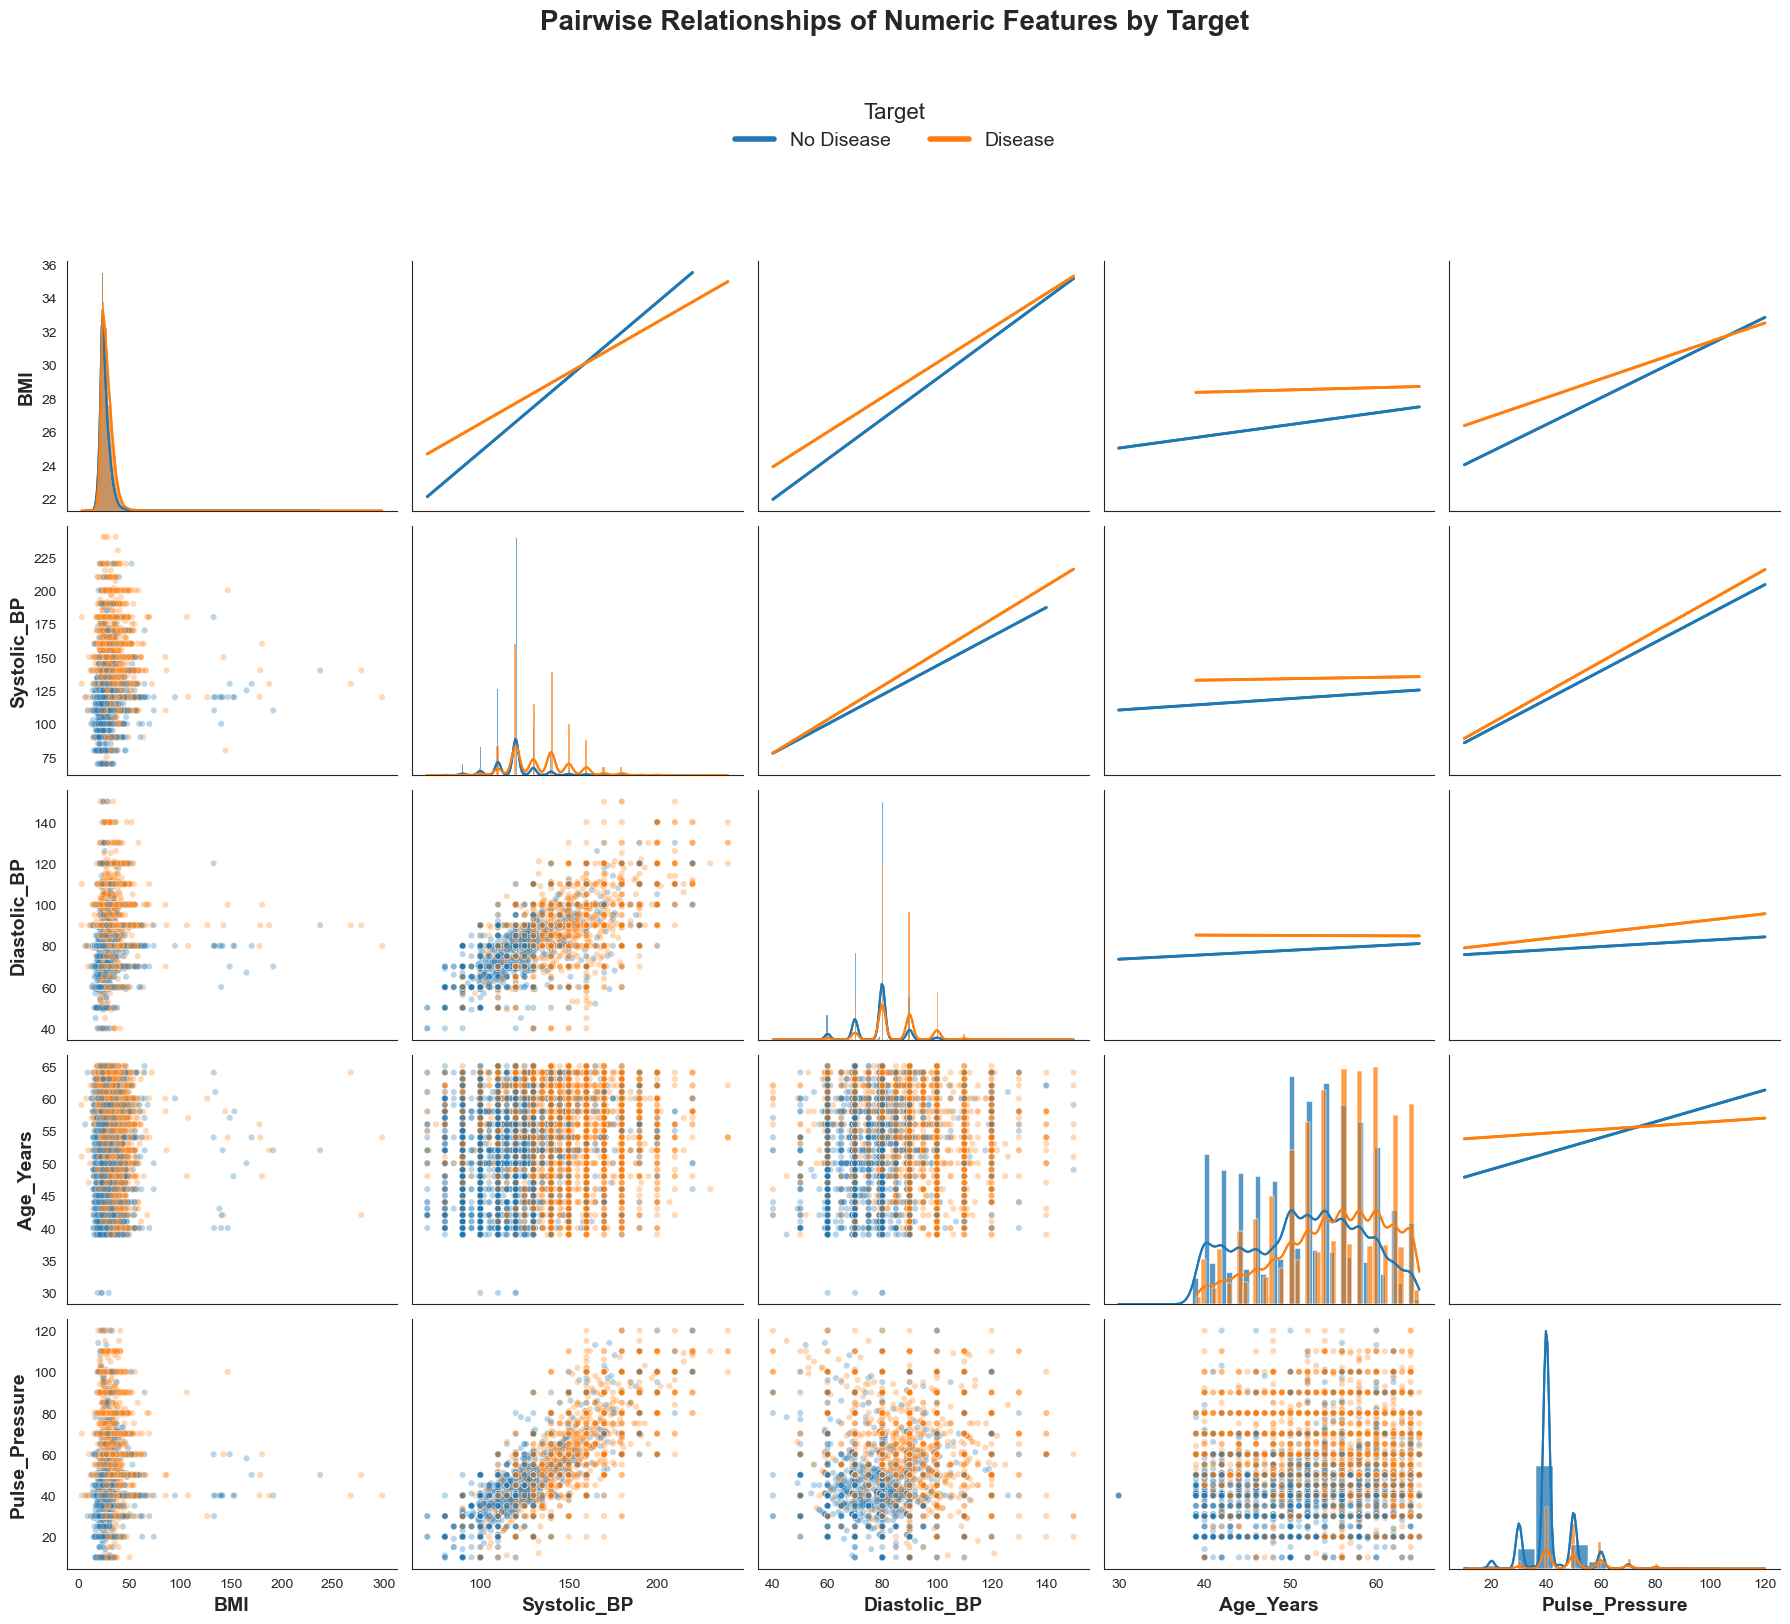

In [24]:
# ---------------------------
# Project root and plot directory outside src
# ---------------------------
try:
    PROJECT_ROOT = Path.cwd().parent.parent.resolve()  # two levels up from src/notebooks
    PLOT_DIR = PROJECT_ROOT / 'reports' / 'visualizations' / 'univariate analysis' / 'numerical analysis'
    PLOT_DIR.mkdir(parents=True, exist_ok=True)  # create folder only if missing
    print(f"[INFO] Using output directory: {PLOT_DIR.resolve()}")
except Exception as e:
    print(f"[ERROR] Could not set up output directory: {e}")
    # Fallback to current directory if there's an issue
    PLOT_DIR = Path.cwd()
    print(f"[INFO] Falling back to current directory: {PLOT_DIR}")

# ---------------------------
# Numeric columns
# ---------------------------
numeric_cols = ['BMI', 'Systolic_BP', 'Diastolic_BP', 'Age_Years', 'Pulse_Pressure']

# ---------------------------
# Target palette
# ---------------------------
TARGET_PALETTE_LIST = ['#1f77b4', '#ff7f0e']  # Blue for No Disease, Orange for Disease
PAIRGRID_PALETTE = dict(zip(['No Disease', 'Disease'], TARGET_PALETTE_LIST))

# ---------------------------
# Prepare DataFrame - avoid modifying original data
# ---------------------------
df_plot = df.copy()
df_plot['target_name'] = df_plot['target'].map({0: 'No Disease', 1: 'Disease'})

# ---------------------------
# Figure sizing based on number of variables
# ---------------------------
n_vars = len(numeric_cols)
fig_height = max(3 * n_vars, 10)  # Minimum height of 10
fig_width = fig_height * 1.2

# ---------------------------
# Styling
# ---------------------------
plt.rcParams['axes.grid'] = False
sns.set_style("white")  # no grid lines

# ---------------------------
# Initialize PairGrid
# ---------------------------
g = sns.PairGrid(
    df_plot,
    vars=numeric_cols,
    hue='target_name',
    palette=PAIRGRID_PALETTE,
    diag_sharey=False,
    height=fig_height/n_vars,
    aspect=1.2
)

# ---------------------------
# Upper: regression lines
# ---------------------------
def reg_by_target(x, y, **kwargs):
    for name, color in PAIRGRID_PALETTE.items():
        subset = df_plot[df_plot['target_name'] == name]
        # Only plot regression if we have enough data points
        if subset[x.name].notna().sum() > 2 and subset[y.name].notna().sum() > 2:
            sns.regplot(
                x=subset[x.name], y=subset[y.name], scatter=False, ci=None,
                line_kws={'color': color, 'label': name, 'linewidth': 2}, ax=plt.gca()
            )

g.map_upper(reg_by_target)

# ---------------------------
# Lower: scatter plot
# ---------------------------
g.map_lower(sns.scatterplot, alpha=0.3, s=20)

# ---------------------------
# Diagonal: histogram
# ---------------------------
def hist_diag(x, **kwargs):
    ax = plt.gca()
    for name, color in PAIRGRID_PALETTE.items():
        subset = df_plot[df_plot['target_name'] == name]
        if subset[x.name].notna().sum() > 1:
            sns.histplot(subset[x.name], color=color, alpha=0.5, kde=True, ax=ax)
    # Remove redundant legend if it exists
    if ax.get_legend():
        ax.get_legend().remove()

g.map_diag(hist_diag)

# ---------------------------
# Remove grid lines from all axes
# ---------------------------
for ax_row in g.axes:
    for ax in ax_row:
        ax.grid(False)

# ---------------------------
# Main title
# ---------------------------
g.fig.suptitle('Pairwise Relationships of Numeric Features by Target', 
             fontsize=20, y=1.08, weight='bold')

# ---------------------------
# Legend below title
# ---------------------------
handles = [plt.Line2D([0], [0], color=color, lw=4, label=name) 
          for name, color in PAIRGRID_PALETTE.items()]
labels = list(PAIRGRID_PALETTE.keys())
g.fig.legend(
    handles, labels, title='Target', title_fontsize=16, fontsize=14,
    loc='upper center', bbox_to_anchor=(0.5, 1.03), ncol=2, frameon=False
)

# ---------------------------
# Axis labels font size
# ---------------------------
for i, var in enumerate(numeric_cols):
    g.axes[i, 0].set_ylabel(var, fontsize=14, fontweight='bold')
    g.axes[-1, i].set_xlabel(var, fontsize=14, fontweight='bold')

plt.tight_layout(rect=(0, 0, 1, 0.95))

# ---------------------------
# Save figure with robust error handling
# ---------------------------
try:
    img_path = PLOT_DIR / '02_Pairwise_Relationships_of_Numeric_Features.png'
    
    # Remove previous file if exists
    if img_path.exists():
        img_path.unlink()
        print(f"[INFO] Removed existing file: {img_path.name}")
    
    # Save the plot
    plt.savefig(img_path, bbox_inches='tight', dpi=150)
    print(f"[SUCCESS] Plot saved to: {img_path.resolve()}")
except Exception as e:
    print(f"[ERROR] Could not save plot: {str(e)}")
finally:
    plt.show()  # Always show the plot regardless of save success

# Clean up memory
plt.close()

### ***Observations:***

* ***Age is the biggest factor:*** Older people are much more likely to have the disease.

* ***High blood pressure is a clear sign:*** People with the disease tend to have higher systolic, diastolic, and pulse pressure readings.

* ***Higher BMI is also linked:*** A higher BMI increases the chances of having the disease, though it's not as strong a factor as age or blood pressure.

***Risks add up:*** The data shows that the highest concentration of disease is among older individuals with high blood pressure.

In [26]:
# ==============================================================================
# NUMERICAL ANALYSIS: Statistical Comparison & Correlation (Strength & Direction)
# ==============================================================================
from scipy.stats import mannwhitneyu, spearmanr

# Define columns to analyze and target column
numeric_cols = ['Age_Years', 'BMI', 'Systolic_BP', 'Diastolic_BP', 'Pulse_Pressure']
target_col = 'target'

# Validate columns exist in dataframe
missing_cols = [col for col in numeric_cols + [target_col] if col not in df.columns]
if missing_cols:
    raise ValueError(f"Missing columns in dataframe: {', '.join(missing_cols)}")

# Set significance level
alpha = 0.05
results = []

# Process each numeric feature
for col in numeric_cols:
    # Filter out NaN values for more robust analysis
    valid_data = df[[col, target_col]].dropna()
    
    # Skip if insufficient data
    if len(valid_data) < 10:
        print(f"Warning: Insufficient data for {col}, skipping...")
        continue
        
    group0 = valid_data[valid_data[target_col] == 0][col]
    group1 = valid_data[valid_data[target_col] == 1][col]
    
    # Skip if any group is too small
    if len(group0) < 5 or len(group1) < 5:
        print(f"Warning: Group size too small for {col}, skipping...")
        continue
    
    # Perform Mann-Whitney U test (non-parametric comparison of distributions)
    stat, p_mwu = mannwhitneyu(group0, group1, alternative='two-sided')
    
    # Calculate descriptive statistics
    median0 = group0.median()
    median1 = group1.median()
    mean0 = group0.mean()
    mean1 = group1.mean()
    
    # Determine direction of difference between groups
    if median1 > median0:
        mwu_direction = "higher"
    elif median1 < median0:
        mwu_direction = "lower"
    else:
        mwu_direction = "equal"
        
    # Calculate Spearman correlation (non-parametric measure of relationship)
    corr, p_corr = spearmanr(valid_data[col], valid_data[target_col], nan_policy='omit')
    
    # Classify correlation strength
    strength = "strong" if abs(corr) > 0.5 else "moderate" if abs(corr) > 0.3 else "weak"
    corr_direction = "positive" if corr > 0 else "negative" if corr < 0 else "none"
    
    # Determine statistical significance
    mwu_significant = "Yes" if p_mwu < alpha else "No"
    corr_significant = "Yes" if p_corr < alpha else "No"
    
    # Add to results
    results.append({
        "Feature": col,
        "MWU_p": p_mwu,
        "MWU_Significant": mwu_significant,
        "Median_NoDisease": median0,
        "Median_Disease": median1,
        "Mean_NoDisease": mean0,
        "Mean_Disease": mean1,
        "MWU_Direction": mwu_direction,
        "Spearman_r": corr,
        "Spearman_p": p_corr,
        "Corr_Significant": corr_significant,
        "Strength": strength,
        "Corr_Direction": corr_direction
    })

# Create and format the results dataframe
results_df = pd.DataFrame(results)

# Format p-values and correlation values for better readability
format_cols = ['MWU_p', 'Spearman_p', 'Spearman_r', 'Mean_NoDisease', 'Mean_Disease']
for col in format_cols:
    if col in results_df.columns:
        results_df[col] = results_df[col].apply(lambda x: f"{x:.4f}")

# Reorder columns for logical flow
col_order = ['Feature', 'Median_NoDisease', 'Median_Disease', 'Mean_NoDisease', 'Mean_Disease', 
             'MWU_Direction', 'MWU_p', 'MWU_Significant', 'Spearman_r', 'Spearman_p', 
             'Corr_Significant', 'Strength', 'Corr_Direction']
results_df = results_df[col_order]

# Display the results
display(results_df)

# Optional: Print a summary of significant findings
significant_features = results_df[results_df['MWU_Significant'] == 'Yes']['Feature'].tolist()
if significant_features:
    print(f"\nSignificant differences found in: {', '.join(significant_features)}")

,Feature,Median_NoDisease,Median_Disease,Mean_NoDisease,Mean_Disease,MWU_Direction,MWU_p,MWU_Significant,Spearman_r,Spearman_p,Corr_Significant,Strength,Corr_Direction
0,Age_Years,52.00000,56.000000,51.6963,54.9120,higher,0.0000,Yes,0.2353,0.0000,Yes,weak,positive
1,BMI,25.47666,27.471384,26.5492,28.5669,higher,0.0000,Yes,0.1990,0.0000,Yes,weak,positive
2,Systolic_BP,120.00000,130.000000,119.6170,134.2975,higher,0.0000,Yes,0.4545,0.0000,Yes,moderate,positive
3,Diastolic_BP,80.00000,80.000000,78.2267,84.9789,equal,0.0000,Yes,0.3642,0.0000,Yes,moderate,positive
4,Pulse_Pressure,40.00000,50.000000,41.4975,49.4441,higher,0.0000,Yes,0.3595,0.0000,Yes,moderate,positive



Significant differences found in: Age_Years, BMI, Systolic_BP, Diastolic_BP, Pulse_Pressure


### ***Observations:***

* **Overall Trend:** Both the graphs and the statistics show that higher numbers for **Age, BMI, and all blood pressure measurements** are linked to having the disease.

* **Strongest Factor:** **Systolic BP** is the most important factor. The difference between the 'Disease' and 'No Disease' groups is very clear in the graph, and the stats confirm it has the strongest connection.

* **Moderate Factors:** **Pulse Pressure** and **Diastolic BP** have a moderate connection to the disease. Interestingly, even though the median **Diastolic BP** is the same for both groups, the overall trend still points toward a link with the disease.

* **Weakest Factors:** **Age** and **BMI** are the weakest predictors. You can see a lot of overlap between the groups in the graph, which the stats confirm.

### Categorical Analysis

In [27]:
# Demographics and physical metrics combined
demographics = ['Age_Group', 'Sex', 'BMI_Category']

# Clinical Biomarkers: Lab results and clinical measurements
clinical_biomarkers = ['Cholesterol_Level', 'Glucose_Level', 'BP_label']

# Lifestyle Factors: Behavioral habits
lifestyle = ['Smoking_Status', 'Alcohol_Intake', 'Physical_Activity']

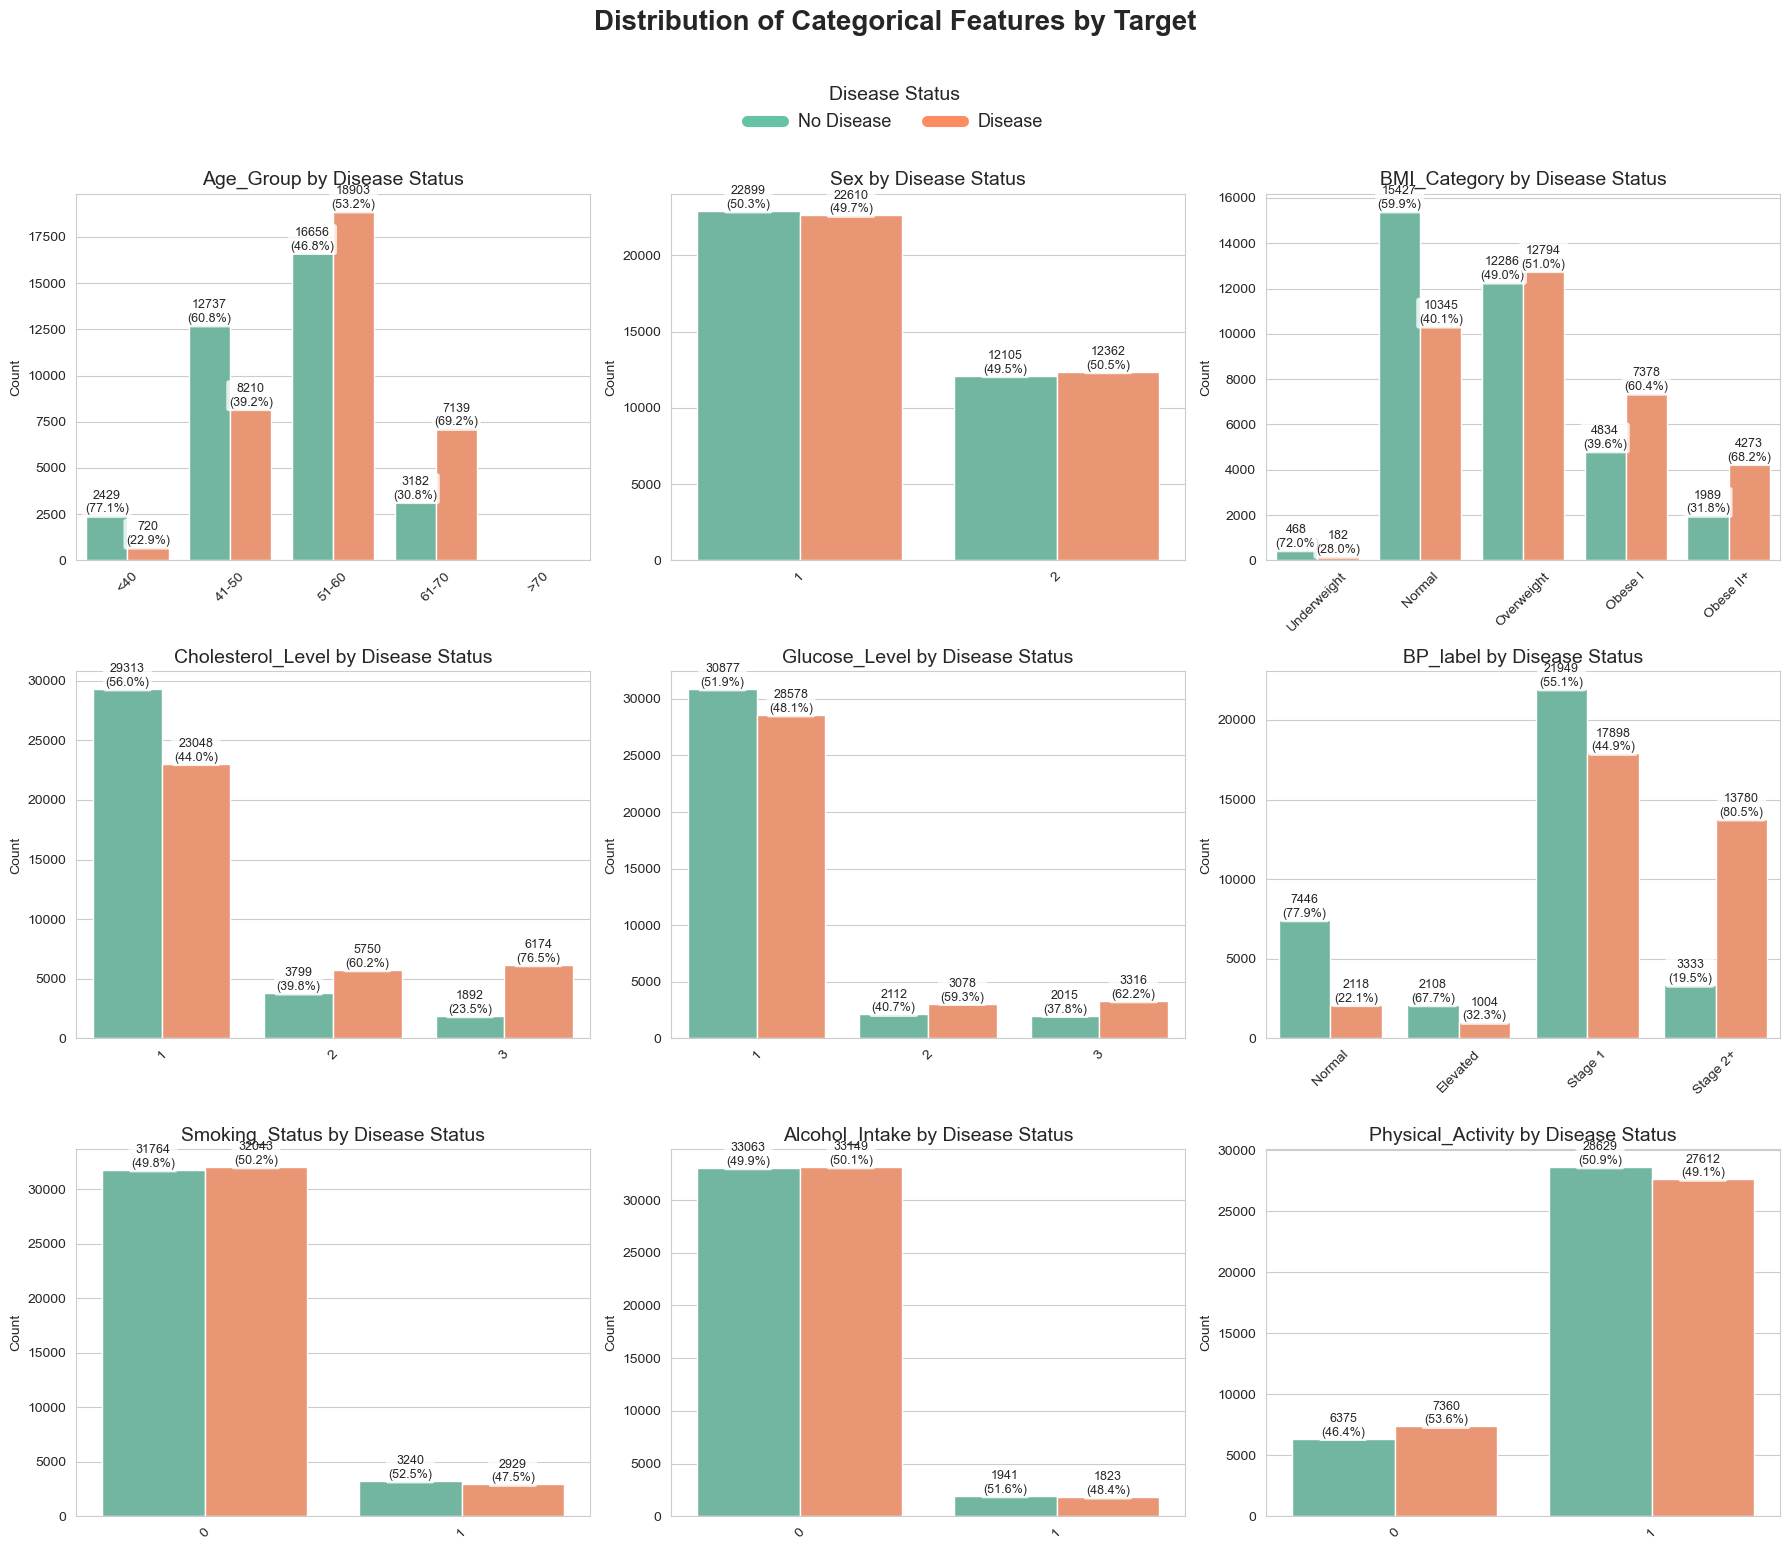

[SUCCESS] Plot saved to: P:\projects\heart disease prediction\reports\visualizations\univariate analysis\categorical analysis\01_Categorical_Distributions_by_Target.png


In [29]:
# --- Categorical features ---
cat_cols = [
    'Age_Group', 'Sex', 'BMI_Category', 'Cholesterol_Level', 'Glucose_Level',
    'BP_label', 'Smoking_Status', 'Alcohol_Intake', 'Physical_Activity'
]

# --- Layout ---
n_cols = 3
n_rows = (len(cat_cols) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
sns.set_style("whitegrid")
axes = axes.flatten()

fig.suptitle('Distribution of Categorical Features by Target',
             fontsize=20, weight='bold', y=1.03)

# --- Plot each categorical variable ---
for i, col in enumerate(cat_cols):
    ax = axes[i]
    
    # Skip if column doesn't exist
    if col not in df.columns:
        print(f"Warning: Column '{col}' not found in DataFrame")
        continue
        
    plot_df = df[[col, 'target']].copy().dropna()
    
    # Create target_name for better labels
    plot_df['target_name'] = plot_df['target'].map({0: 'No Disease', 1: 'Disease'})
    
    # Get category order for proper mapping
    if pd.api.types.is_categorical_dtype(plot_df[col]):
        categories = list(plot_df[col].cat.categories)
    else:
        # If not categorical, get unique values
        categories = list(plot_df[col].unique())
        
    # Create mapping from position to category
    if pd.api.types.is_numeric_dtype(plot_df[col]) and not pd.api.types.is_categorical_dtype(plot_df[col]):
        plot_df[col] = plot_df[col].astype(str)

    # Plot grouped countplot using meaningful target labels
    sns_plot = sns.countplot(
        data=plot_df,
        x=col,
        hue='target_name',  # Use descriptive labels
        palette='Set2',
        ax=ax,
        dodge=True,
        legend=False
    )
    
    # Get total counts per category (more robust)
    value_counts = plot_df[col].value_counts()
    
    # Calculate percentages and counts for each bar
    for p in ax.patches:
        height = p.get_height()
        if height <= 0:  # Skip bars with no height
            continue
            
        # Get x-position of bar center
        x_pos = p.get_x() + p.get_width() / 2
        
        # Find the closest category position
        pos_idx = int(round(x_pos * 2)) // 2  # Handle dodge position
        if pos_idx >= len(categories):
            continue  # Skip if index out of bounds
            
        # Calculate percentage based on appropriate category count
        cat_idx = int(pos_idx)
        if cat_idx < len(categories):
            cat_name = categories[cat_idx]
            if cat_name in value_counts.index:
                total = value_counts[cat_name]
                percentage = f'{(height/total)*100:.1f}%'
                
                # Add label with count and percentage
                ax.text(x_pos, height + 0.1,
                       f'{int(height)}\n({percentage})',
                       ha='center', va='bottom', fontsize=9,
                       bbox=dict(boxstyle="round,pad=0.2", facecolor='white', 
                               alpha=0.8, edgecolor='none'))

    ax.set_title(f'{col} by Disease Status', fontsize=14)  # More descriptive title
    ax.set_xlabel('')
    ax.set_ylabel('Count')
    ax.tick_params(axis='x', rotation=45)

# --- Hide unused axes ---
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout(rect=(0, 0, 1, 0.96))

# --- Legend with meaningful labels ---
handles = [
    Line2D([0], [0], color=sns.color_palette('Set2')[0], lw=8, label='No Disease'),
    Line2D([0], [0], color=sns.color_palette('Set2')[1], lw=8, label='Disease')
]
fig.legend(
    handles=handles,
    labels=['No Disease', 'Disease'],
    title='Disease Status',  # More descriptive title
    loc='upper center',
    bbox_to_anchor=(0.5, 0.99),
    ncol=2,
    frameon=False,
    fontsize=13,
    title_fontsize=14
)

# --- Save plot with robust path handling ---
try:
    PLOT_DIR = Path.cwd().parent.parent / 'reports' / 'visualizations' / 'univariate analysis' / 'categorical analysis'
    PLOT_DIR.mkdir(parents=True, exist_ok=True)

    img_path = PLOT_DIR / '01_Categorical_Distributions_by_Target.png'
    plt.savefig(img_path, bbox_inches='tight', dpi=150)
    plt.show()

    print(f"[SUCCESS] Plot saved to: {img_path.resolve()}")
except Exception as e:
    print(f"[ERROR] Failed to save plot: {str(e)}")
    # Still show the plot even if saving fails
    plt.show()

### ***Observations:***

***Strongest Factors Linked to Target 1:***

These are the conditions where individuals are much more likely to be in the Target 1 (orange) group:

* **Older Age:** The chances of being in Target 1 increase significantly with age.

* **High Blood Pressure:** This is the strongest indicator. Anyone in a hypertension category is overwhelmingly in Target 1.

* **High BMI:** Being overweight or obese is strongly associated with Target 1.

* **High Cholesterol & Glucose:** Elevated levels of both are clear indicators for Target 1.

* **Physical Inactivity:** A lack of physical activity shows a very strong link to Target 1.

***Factors with No Clear Link:***

These characteristics do not appear to be useful for predicting the target variable based on this data:

* **Smoking Status:** Smokers and non-smokers have a nearly identical split between Target 0 and Target 1.

* **Alcohol Intake:** Similar to smoking, this habit shows no connection to the target.

* **Sex:** The distribution between Target 0 and 1 is roughly the same for both sexes.

**Distribution:**
* target is roughly balanced 
* rest most the features are imbalanced

### -> Clinical_biomarkers

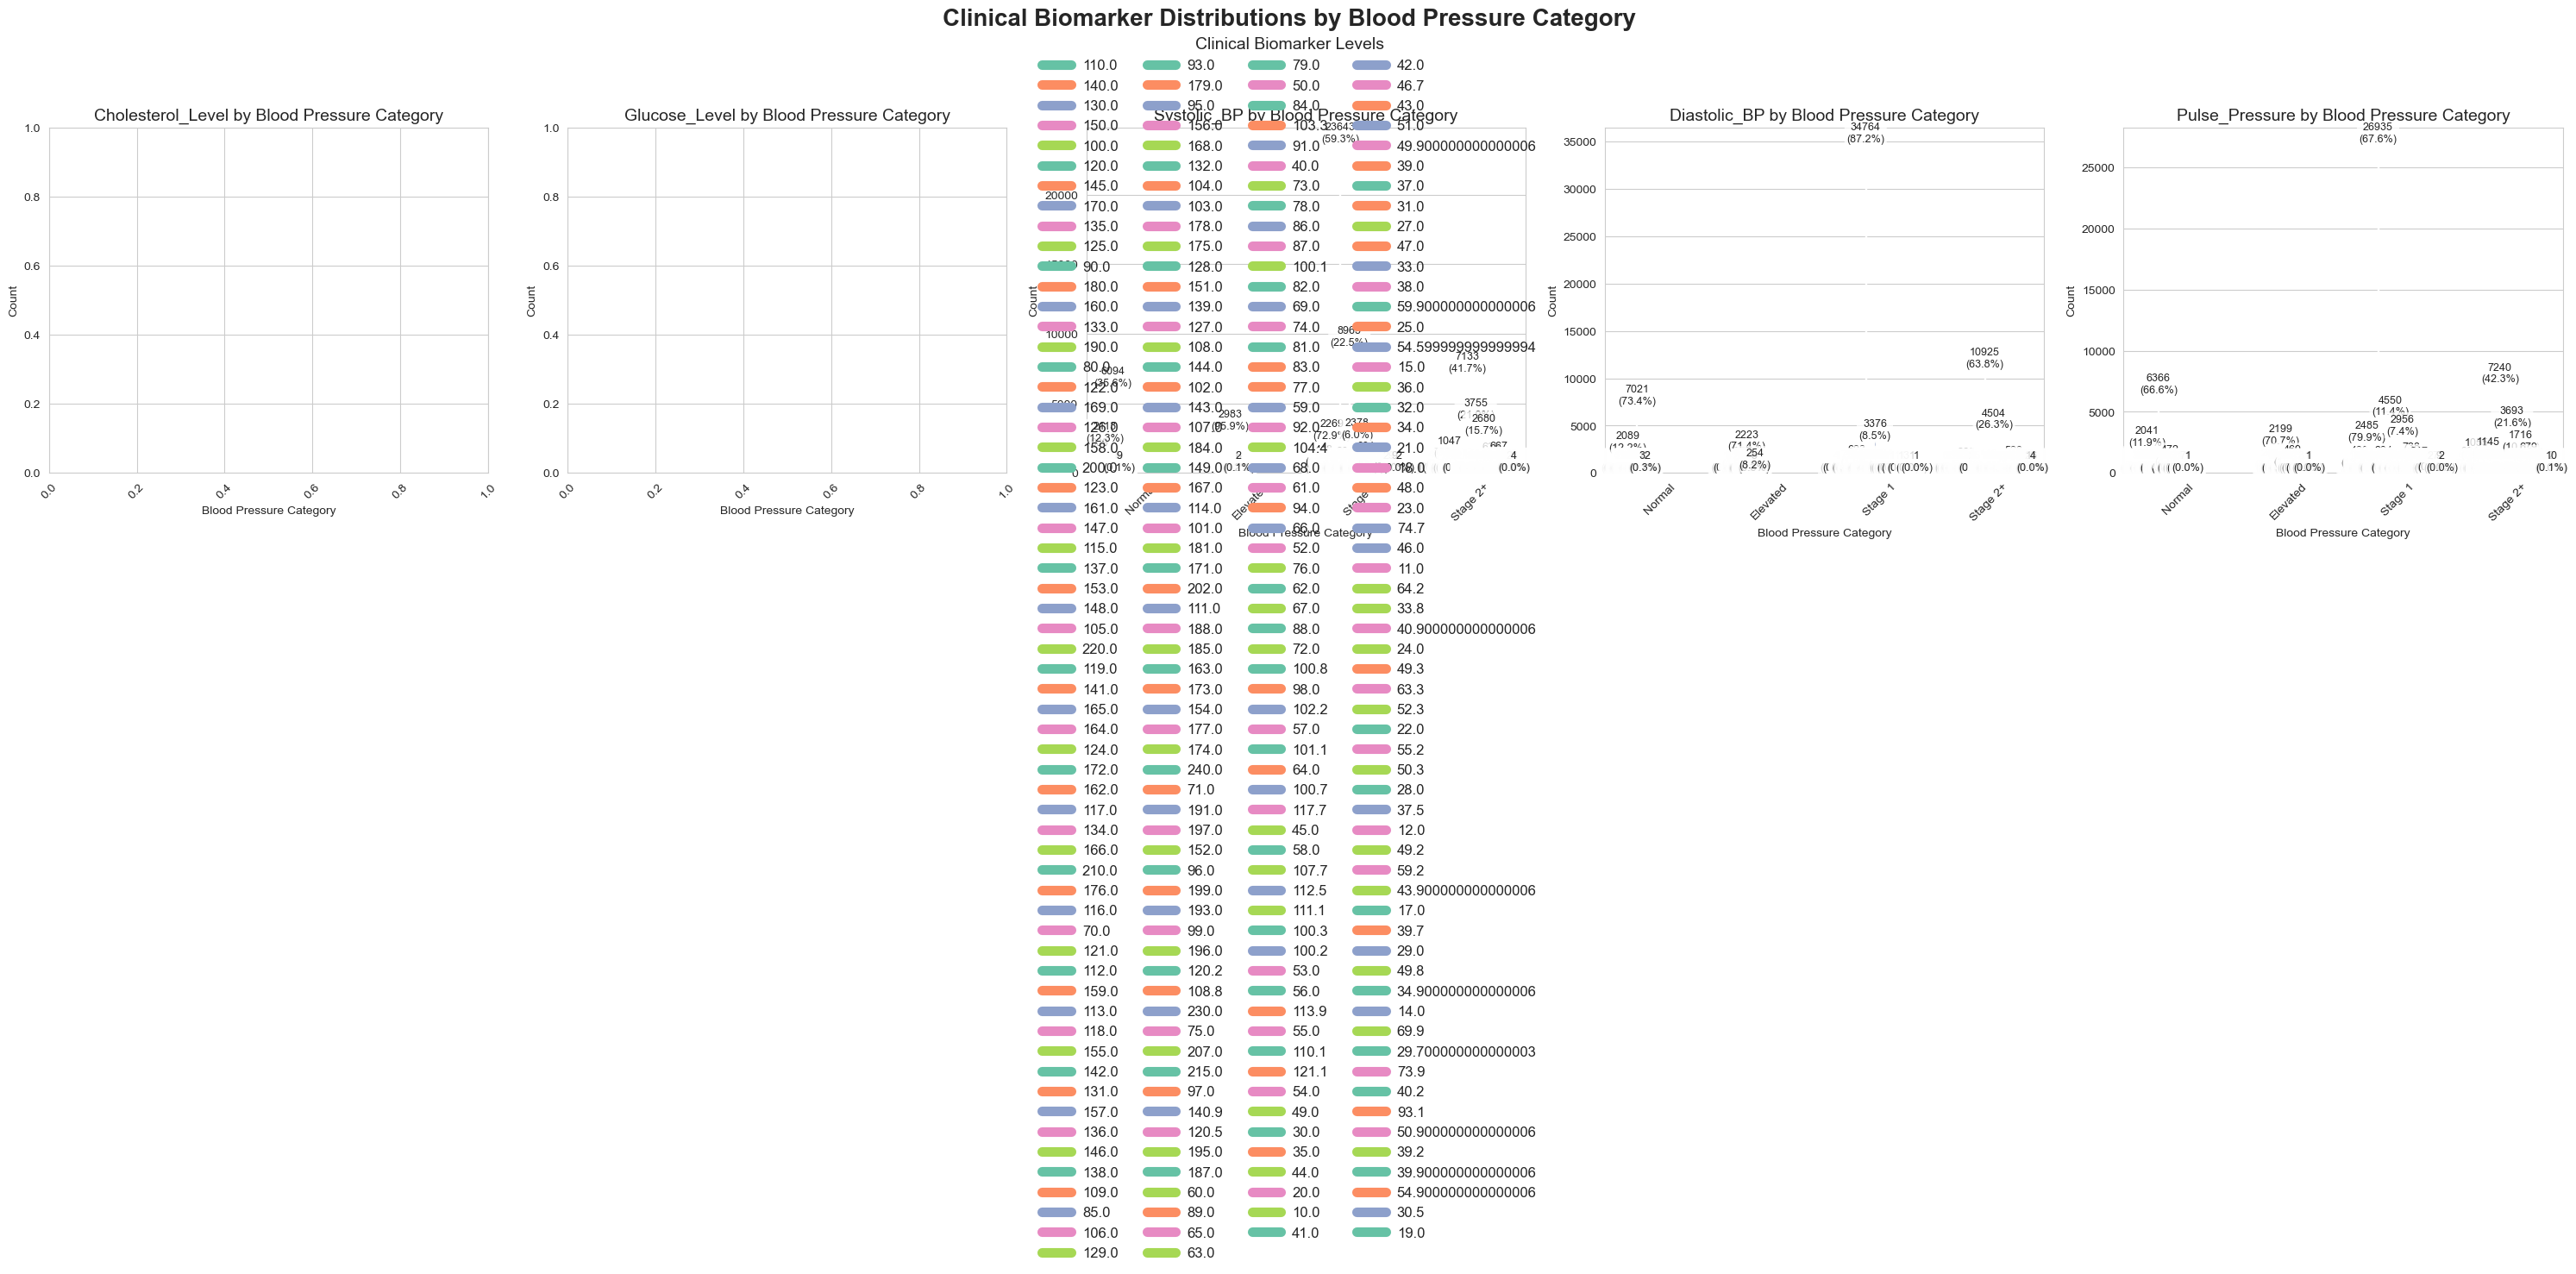

[SUCCESS] Plot saved to: P:\projects\heart disease prediction\reports\visualizations\univariate analysis\categorical analysis\02_Clinical_Biomarker_Distributions_by_BP_Category.png


In [34]:
# …existing code…
# Define category order for consistent plotting
category_orders = {
    'Cholesterol_Level': ['Normal', 'Above Normal', 'Well Above Normal'],
    'Glucose_Level':    ['Normal', 'Above Normal', 'Well Above Normal'],
    'BP_label':         ['Normal', 'Elevated', 'Stage 1', 'Stage 2+']
}

# Map numeric codes to string labels and cast to ordered categorical
chol_map = {1: 'Normal', 2: 'Above Normal', 3: 'Well Above Normal'}
gluc_map = {1: 'Normal', 2: 'Above Normal', 3: 'Well Above Normal'}

# always map these two, regardless of their current dtype
for col, mapping in [('Cholesterol_Level', chol_map),
                     ('Glucose_Level',    gluc_map)]:
    if col in df.columns:
        df[col] = df[col].map(mapping)
        df[col] = pd.Categorical(
            df[col],
            categories=category_orders[col],
            ordered=True
        )

n = len(clinical_biomarkers)
# Create a color palette with distinct colors for each clinical biomarker
color_palette = sns.color_palette("Set2", n)
fig, axes = plt.subplots(1, n, figsize=(6 * n, 6))
sns.set_style("whitegrid")
fig.suptitle('Clinical Biomarker Distributions by Blood Pressure Category',
             fontsize=20, weight='bold', y=1.05)
for i, col in enumerate(clinical_biomarkers):
    ax = axes[i]
    if col not in df.columns:
        print(f"Warning: Column '{col}' not found in DataFrame")
        continue
    
    plot_df = df[[col, 'BP_label']].copy().dropna()
    
    # Create BP_label as ordered categorical if not already
    if not pd.api.types.is_categorical_dtype(plot_df['BP_label']):
        plot_df['BP_label'] = pd.Categorical(
            plot_df['BP_label'],
            categories=category_orders['BP_label'],
            ordered=True
        )
    
    # Plot countplot with distinct colors
    sns_plot = sns.countplot(
        data=plot_df,
        x='BP_label',
        hue=col,
        palette=[color_palette[j % n] for j in range(len(plot_df[col].unique()))],
        ax=ax,
        dodge=True,
        legend=False
    )
    
    # Get total counts per BP category for percentage calculation
    value_counts = plot_df['BP_label'].value_counts()
    
    # Add count and percentage labels to each bar
    for p in ax.patches:
        height = p.get_height()
        if height <= 0:  # Skip bars with no height
            continue
            
        # Get x-position of bar center
        x_pos = p.get_x() + p.get_width() / 2
        
        # Find the closest category position
        pos_idx = int(round(x_pos * 2)) // 2  # Handle dodge position
        if pos_idx >= len(category_orders['BP_label']):
            continue  # Skip if index out of bounds
            
        # Calculate percentage based on appropriate category count
        cat_idx = int(pos_idx)
        if cat_idx < len(category_orders['BP_label']):
            cat_name = category_orders['BP_label'][cat_idx]
            if cat_name in value_counts.index:
                total = value_counts[cat_name]
                percentage = f'{(height/total)*100:.1f}%'
                
                # Add label with count and percentage
                ax.text(x_pos, height + 0.1,
                       f'{int(height)}\n({percentage})',
                       ha='center', va='bottom', fontsize=9,
                       bbox=dict(boxstyle="round,pad=0.2", facecolor='white', 
                               alpha=0.8, edgecolor='none'))

    ax.set_title(f'{col} by Blood Pressure Category', fontsize=14)
    ax.set_xlabel('Blood Pressure Category')
    ax.set_ylabel('Count')
    ax.tick_params(axis='x', rotation=45)
# Hide unused axes if any
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)
plt.tight_layout(rect=(0, 0, 1, 0.95))
# Legend with distinct colors
handles = []
labels = []
unique_values = set()
for col in clinical_biomarkers:
    if col in df.columns:
        unique_vals = df[col].dropna().unique()
        for j, val in enumerate(unique_vals):
            if val not in unique_values:
                unique_values.add(val)
                handles.append(Line2D([0], [0], color=color_palette[j % n], lw=8, label=val))
                labels.append(val)
fig.legend(
    handles=handles,
    labels=labels,
    title='Clinical Biomarker Levels',
    loc='upper center',
    bbox_to_anchor=(0.5, 1.02),
    ncol=min(len(labels), 4),
    frameon=False,
    fontsize=12,
    title_fontsize=14
)
# Save plot with robust path handling
try:
    PLOT_DIR = Path.cwd().parent.parent / 'reports' / 'visualizations' / 'univariate analysis' / 'categorical analysis'
    PLOT_DIR.mkdir(parents=True, exist_ok=True)

    img_path = PLOT_DIR / '02_Clinical_Biomarker_Distributions_by_BP_Category.png'
    plt.savefig(img_path, bbox_inches='tight', dpi=150)
    plt.show()

    print(f"[SUCCESS] Plot saved to: {img_path.resolve()}")
except Exception as e:
    print(f"[ERROR] Failed to save plot: {e}")
    plt.show()

### **Observations**

* **Blood Pressure:**
    * **Disease Risk:** Higher blood pressure is strongly linked to the disease. The disease rate is **over 3 times higher** for those in hypertensive crisis (69.1%) compared to those with normal BP (22.2%).
    * **Population Habits:** The heatmaps show that **Hypertension Stage 1** is the most common condition in this dataset. It frequently occurs with normal cholesterol levels (in 44.6% of people) and normal glucose levels (in 49.3% of people).

* **Cholesterol:**
    * **Disease Risk:** This is a major risk factor. The chance of disease **nearly doubles**, rising from 44.0% in the lowest cholesterol group to 76.5% in the highest.
    * **Population Habits:** The heatmaps reveal that the most common profile is having **normal cholesterol (Level 1) while also having Hypertension Stage 1**. This combination describes a large portion of the population (44.6%).

* **Glucose:**
    * **Disease Risk:** High blood sugar is a clear warning sign. The disease rate shows a **significant increase**, rising from 48.1% in the lowest glucose group to 62.2% in the highest.
    * **Population Habits:** Similar to cholesterol, the most frequent combination is having **normal glucose levels (Level 1) alongside Hypertension Stage 1**, which accounts for nearly half the people in the dataset (49.3%).

In [31]:
# --- Define features and category orders ---
clinical_biomarkers = ['Cholesterol_Level', 'Glucose_Level', 'Systolic_BP', 'Diastolic_BP', 'Pulse_Pressure']
target_col = 'target'

category_orders = {
    'Cholesterol_Level': ['Normal', 'Above Normal', 'Well Above Normal'],
    'Glucose_Level': ['Normal', 'Above Normal', 'Well Above Normal'],
}

# --- Map integer codes to string labels ---
chol_map = {1: 'Normal', 2: 'Above Normal', 3: 'Well Above Normal'}
gluc_map = {1: 'Normal', 3: 'Well Above Normal', 2: 'Above Normal'}  # Note: Changed order to match data

# --- Apply mappings with validation ---
if 'Cholesterol_Level' in df.columns and df['Cholesterol_Level'].dtype != 'O':
    df['Cholesterol_Level'] = df['Cholesterol_Level'].map(chol_map)
if 'Glucose_Level' in df.columns and df['Glucose_Level'].dtype != 'O':
    df['Glucose_Level'] = df['Glucose_Level'].map(gluc_map)

# --- Convert to categorical with proper ordering ---
for col, order in category_orders.items():
    if col in df.columns:
        df[col] = pd.Categorical(df[col], categories=order, ordered=True)

results = []
for col in clinical_biomarkers:
    if col not in df.columns:
        print(f"Skipping '{col}' because it is not in the DataFrame.")
        continue
        
    valid = df[[col, target_col]].dropna()
    if valid.empty:
        print(f"Skipping '{col}' due to all values missing after dropna.")
        continue
        
    ct = pd.crosstab(valid[col], valid[target_col])
    if ct.empty:
        print(f"Skipping '{col}' due to no data, resulting in an empty crosstab.")
        continue

    chi2, p, dof, expected = chi2_contingency(ct)
    n = ct.values.sum()
    phi2 = chi2 / n
    r, k = ct.shape
    cramers_v = (phi2 / min(k - 1, r - 1)) ** 0.5 if min(k - 1, r - 1) > 0 else 0

    direction = None
    if 1 in ct.columns:
        rates = ct.div(ct.sum(axis=1), axis=0)[1]
        if not rates.empty and len(rates) > 1 and not (pd.isna(rates.iloc[0]) or pd.isna(rates.iloc[-1])):
            if rates.iloc[-1] > rates.iloc[0]:
                direction = "positive"
            elif rates.iloc[-1] < rates.iloc[0]:
                direction = "negative"
            else:
                direction = "equal"

    results.append({
        "Feature": col,
        "Chi2_p": p,
        "CramersV": cramers_v,
        "Direction": direction
    })

results_df = pd.DataFrame(results)
results_df = results_df[["Feature", "Chi2_p", "CramersV", "Direction"]]
display(results_df)

,Feature,Chi2_p,CramersV,Direction
0,Cholesterol_Level,0.000000e+00,0.221120,positive
1,Glucose_Level,5.150929e-128,0.091526,positive
2,Systolic_BP,0.000000e+00,0.470166,positive
3,Diastolic_BP,0.000000e+00,0.376394,positive
4,Pulse_Pressure,0.000000e+00,0.369887,positive


### ***Observations:***

* **Blood Pressure: The Strongest Warning Sign**
    This is the **most important predictor** of the three. The link is very clear and strong. The risk of having the disease skyrockets from **22%** in the 'Normal' blood pressure group to **89%** in the 'Hypertensive Crisis' group.

*  **Cholesterol: A Moderate Risk Factor**
    Higher cholesterol is also a significant factor, though not as strong as blood pressure. The disease rate rises from **56%** for people with the lowest cholesterol level to over **78%** for those with the highest level.

*  **Glucose: The Weakest Link**
    While still a factor, high glucose has the **weakest connection** to the disease among these three. The risk increases more modestly, from **48%** at the lowest level to **62%** at the highest.

### -> Demographics

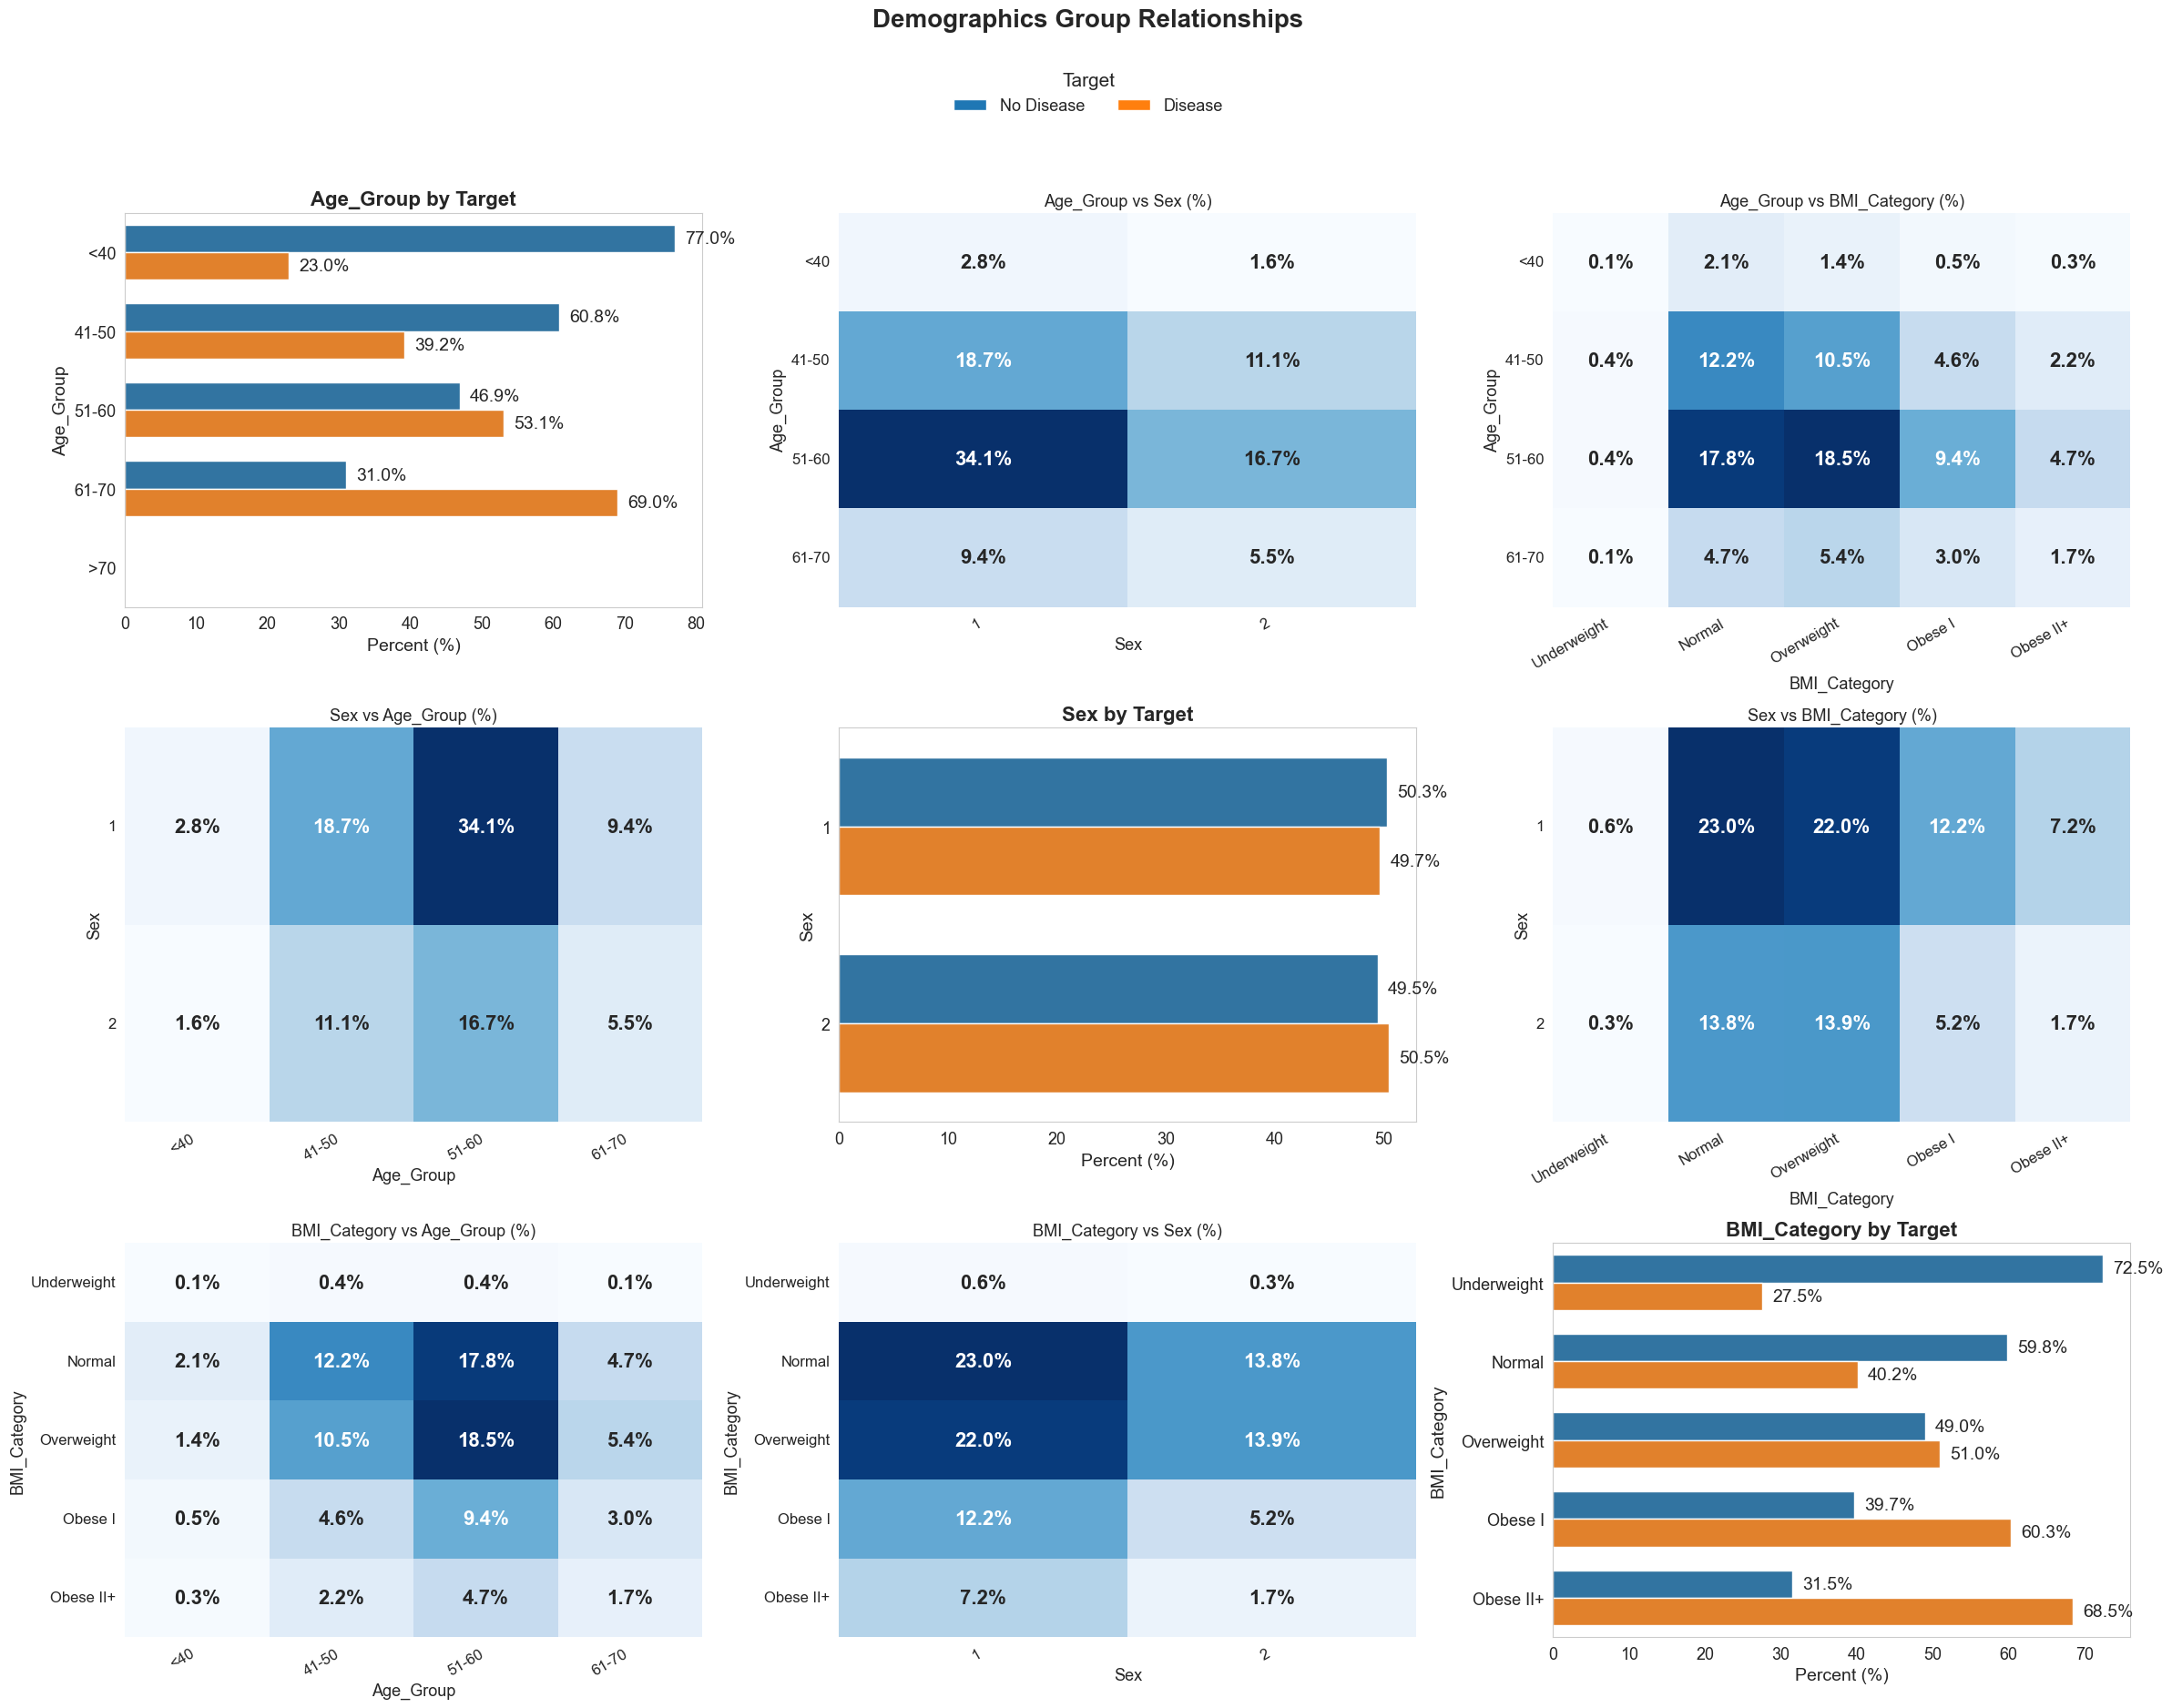

[SUCCESS] Plot saved (overwritten if existed) to: P:\projects\heart disease prediction\reports\visualizations\univariate analysis\categorical analysis\04_Demographics_Group_Relationships.png


In [24]:
# ---------------------------
# Demographic features
# ---------------------------
demographics = ['Age_Group', 'Sex', 'BMI_Category']

# ---------------------------
# Ensure target_name exists
# ---------------------------
if 'target_name' not in df.columns and 'target' in df.columns:
    df['target_name'] = df['target'].map({0: 'No Disease', 1: 'Disease'})

TARGET_PALETTE = {'No Disease': '#1f77b4', 'Disease': '#ff7f0e'}
target_labels = list(TARGET_PALETTE.keys())
n = len(demographics)

# ---------------------------
# Directory to save plots (create only if missing)
# ---------------------------
PLOT_DIR = PROJECT_ROOT / 'reports' / 'visualizations' / 'univariate analysis' / 'categorical analysis'
if not PLOT_DIR.exists():
    PLOT_DIR.mkdir(parents=True, exist_ok=True)

# ---------------------------
# Figure layout
# ---------------------------
fig, axes = plt.subplots(n, n, figsize=(8*n, 6*n), squeeze=False)

# ---------------------------
# Plotting
# ---------------------------
for i, row_feat in enumerate(demographics):
    for j, col_feat in enumerate(demographics):
        ax = axes[i, j]
        if i == j:
            # Diagonal: Grouped barplot by target (% labels)
            ct = pd.crosstab(df[row_feat], df['target_name'])
            ct = ct.loc[ct.sum(axis=1) > 0]  # remove empty rows
            ct_pct = ct.div(ct.sum(axis=1), axis=0) * 100
            ct_pct = ct_pct.reset_index().melt(
                id_vars=row_feat, var_name='target_name', value_name='percent'
            )

            sns.barplot(
                data=ct_pct, y=row_feat, x='percent', hue='target_name',
                palette=TARGET_PALETTE, ax=ax, dodge=True, width=0.7,
                orient='h', legend=False
            )
            for c in ax.containers:
                ax.bar_label(c, fmt='%.1f%%', fontsize=14, padding=8, label_type='edge')

            ax.set_ylabel(row_feat, fontsize=14)
            ax.set_xlabel('Percent (%)', fontsize=14)
            ax.set_title(f'{row_feat} by Target', fontsize=16, weight='bold')
            ax.grid(False)
            ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha='right', fontsize=13)
            ax.set_xticklabels(ax.get_xticklabels(), fontsize=13)

        else:
            # Off-diagonal: Heatmap of joint distribution (% of total)
            ct = pd.crosstab(df[row_feat], df[col_feat])
            ct = ct.loc[ct.sum(axis=1) > 0, ct.sum(axis=0) > 0]  # remove empty bins
            if ct.shape[0] > 0 and ct.shape[1] > 0:
                ct_pct = ct / ct.values.sum() * 100
                hm = sns.heatmap(
                    ct_pct, annot=True, fmt='.1f', cmap='Blues', cbar=False, ax=ax,
                    annot_kws={"fontsize": 16, "fontweight": "bold"}
                )
                for text in hm.texts:
                    text.set_text(f"{text.get_text()}%")
                ax.set_xlabel(col_feat, fontsize=13)
                ax.set_ylabel(row_feat, fontsize=13)
                ax.set_title(f'{row_feat} vs {col_feat} (%)', fontsize=13)
                ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right', fontsize=12)
                ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=12)
            else:
                ax.axis('off')

# ---------------------------
# Main title and legend
# ---------------------------
fig.suptitle('Demographics Group Relationships', fontsize=20, weight='bold', y=1.04)
handles = [Patch(facecolor=TARGET_PALETTE[name], label=name) for name in target_labels]
fig.legend(
    handles=handles, labels=target_labels, title='Target', title_fontsize=15, fontsize=13,
    loc='upper center', bbox_to_anchor=(0.5, 1.01), ncol=len(target_labels), frameon=False
)

plt.tight_layout(rect=(0, 0, 1, 0.96))

# ---------------------------
# Save figure (overwrite if exists)
# ---------------------------
img_path = PLOT_DIR / '04_Demographics_Group_Relationships.png'
try:
    plt.savefig(img_path, bbox_inches='tight', dpi=150)  # overwrite directly
    plt.show()
    print(f"[SUCCESS] Plot saved (overwritten if existed) to: {img_path.resolve()}")
except Exception as e:
    print(f"[ERROR] Could not save plot: {e}")

# ---------------------------
# Cleanup
# ---------------------------
df.drop(['target_name'], axis=1, inplace=True, errors='ignore')

***Observations:***

* **Age Group:**
    * **Disease Risk:** Age is a huge factor. The chance of having the disease **triples**, rising from 23.0% in the youngest group (`<40`) to 69.0% in the oldest group (`61-70`).
    * **Population Habits:** The heatmaps show the study population is heavily concentrated in the **'51-60' age bracket**. The single largest demographic is Sex '1' within this age group (34.1%).

* **BMI Category:**
    * **Disease Risk:** Higher BMI is strongly linked to higher disease risk, which increases from 40.1% for 'Normal' to 68.4% for 'Obese II+. Surprisingly, the **'Underweight' group has the highest disease rate** of all at 72.5%.
    * **Population Habits:** The most common profile is an individual in their 50s with a **'Normal' (17.8%) or 'Overweight' (18.5%) BMI**.

* **Sex:**
    * **Disease Risk:** Sex **does not make a significant difference**. The disease rate is almost exactly 50/50 for both groups.
    * **Population Habits:** The heatmaps show that the study population is not evenly split by sex within age groups. For example, the large **'51-60' age group** is predominantly composed of individuals from Sex '1' (34.1%) over Sex '2' (16.7%).

In [25]:
# Ensure correct columns exist and are not mislabelled
expected_demographics = ['Age_Group', 'Sex', 'BMI_Category']
for col in expected_demographics:
    if col not in df.columns:
        raise ValueError(f"Column '{col}' not found in DataFrame. Check column names and feature engineering steps.")

# Ensure correct dtype for each demographic variable
if not pd.api.types.is_categorical_dtype(df['Age_Group']):
    df['Age_Group'] = df['Age_Group'].astype('category')
if not pd.api.types.is_categorical_dtype(df['BMI_Category']):
    df['BMI_Category'] = df['BMI_Category'].astype('category')
if not pd.api.types.is_categorical_dtype(df['Sex']):
    df['Sex'] = df['Sex'].astype('category')

demographics = ['Age_Group', 'Sex', 'BMI_Category']
target_col = 'target'

results = []
for col in demographics:
    ct = pd.crosstab(df[col], df[target_col])
    if ct.empty:
        print(f"Skipping '{col}' due to no data, resulting in an empty crosstab.")
        continue
    chi2, p, dof, expected = chi2_contingency(ct)
    n = ct.values.sum()
    phi2 = chi2 / n
    r, k = ct.shape
    cramers_v = (phi2 / min(k - 1, r - 1)) ** 0.5 if min(k - 1, r - 1) > 0 else 0
    # Direction: difference in disease rate between highest and lowest category
    rates = ct.div(ct.sum(axis=1), axis=0)[1] if 1 in ct.columns else None
    direction = None
    if rates is not None and len(rates) > 1:
        if not (pd.isna(rates.iloc[0]) or pd.isna(rates.iloc[-1])):
            if rates.iloc[-1] > rates.iloc[0]:
                direction = "positive"
            elif rates.iloc[-1] < rates.iloc[0]:
                direction = "negative"
            else:
                direction = "equal"
    results.append({
        "Feature": col,
        "Chi2_p": p,
        "CramersV": cramers_v,
        "Direction": direction
    })

results_df = pd.DataFrame(results)
results_df = results_df[["Feature", "Chi2_p", "CramersV", "Direction"]]
display(results_df)

,Feature,Chi2_p,CramersV,Direction
0,Age_Group,0.000000,0.224768,positive
1,Sex,0.039534,0.007804,positive
2,BMI_Category,0.000000,0.189426,positive


### ***Observations:***

* **Age: The Strongest Factor**
    **Age is the most important demographic predictor.** The risk of having the disease increases significantly as people get older. The chance of disease starts at just **23%** for those under 40 and climbs to **69%** for the 61-70 age group.

*  **BMI: Also a Strong Factor**
    **Body Mass Index (BMI) is another very strong risk factor.** A higher BMI is clearly linked to a higher disease risk. The risk goes from **27.5%** for the 'Underweight' category up to **68%** for the most obese category.

*  **Sex: Not a Significant Factor**
    **Sex has a very weak and practically irrelevant link** to the disease. The disease rates are nearly identical for both sexes, hovering around **50%**.

### -> Lifestyle

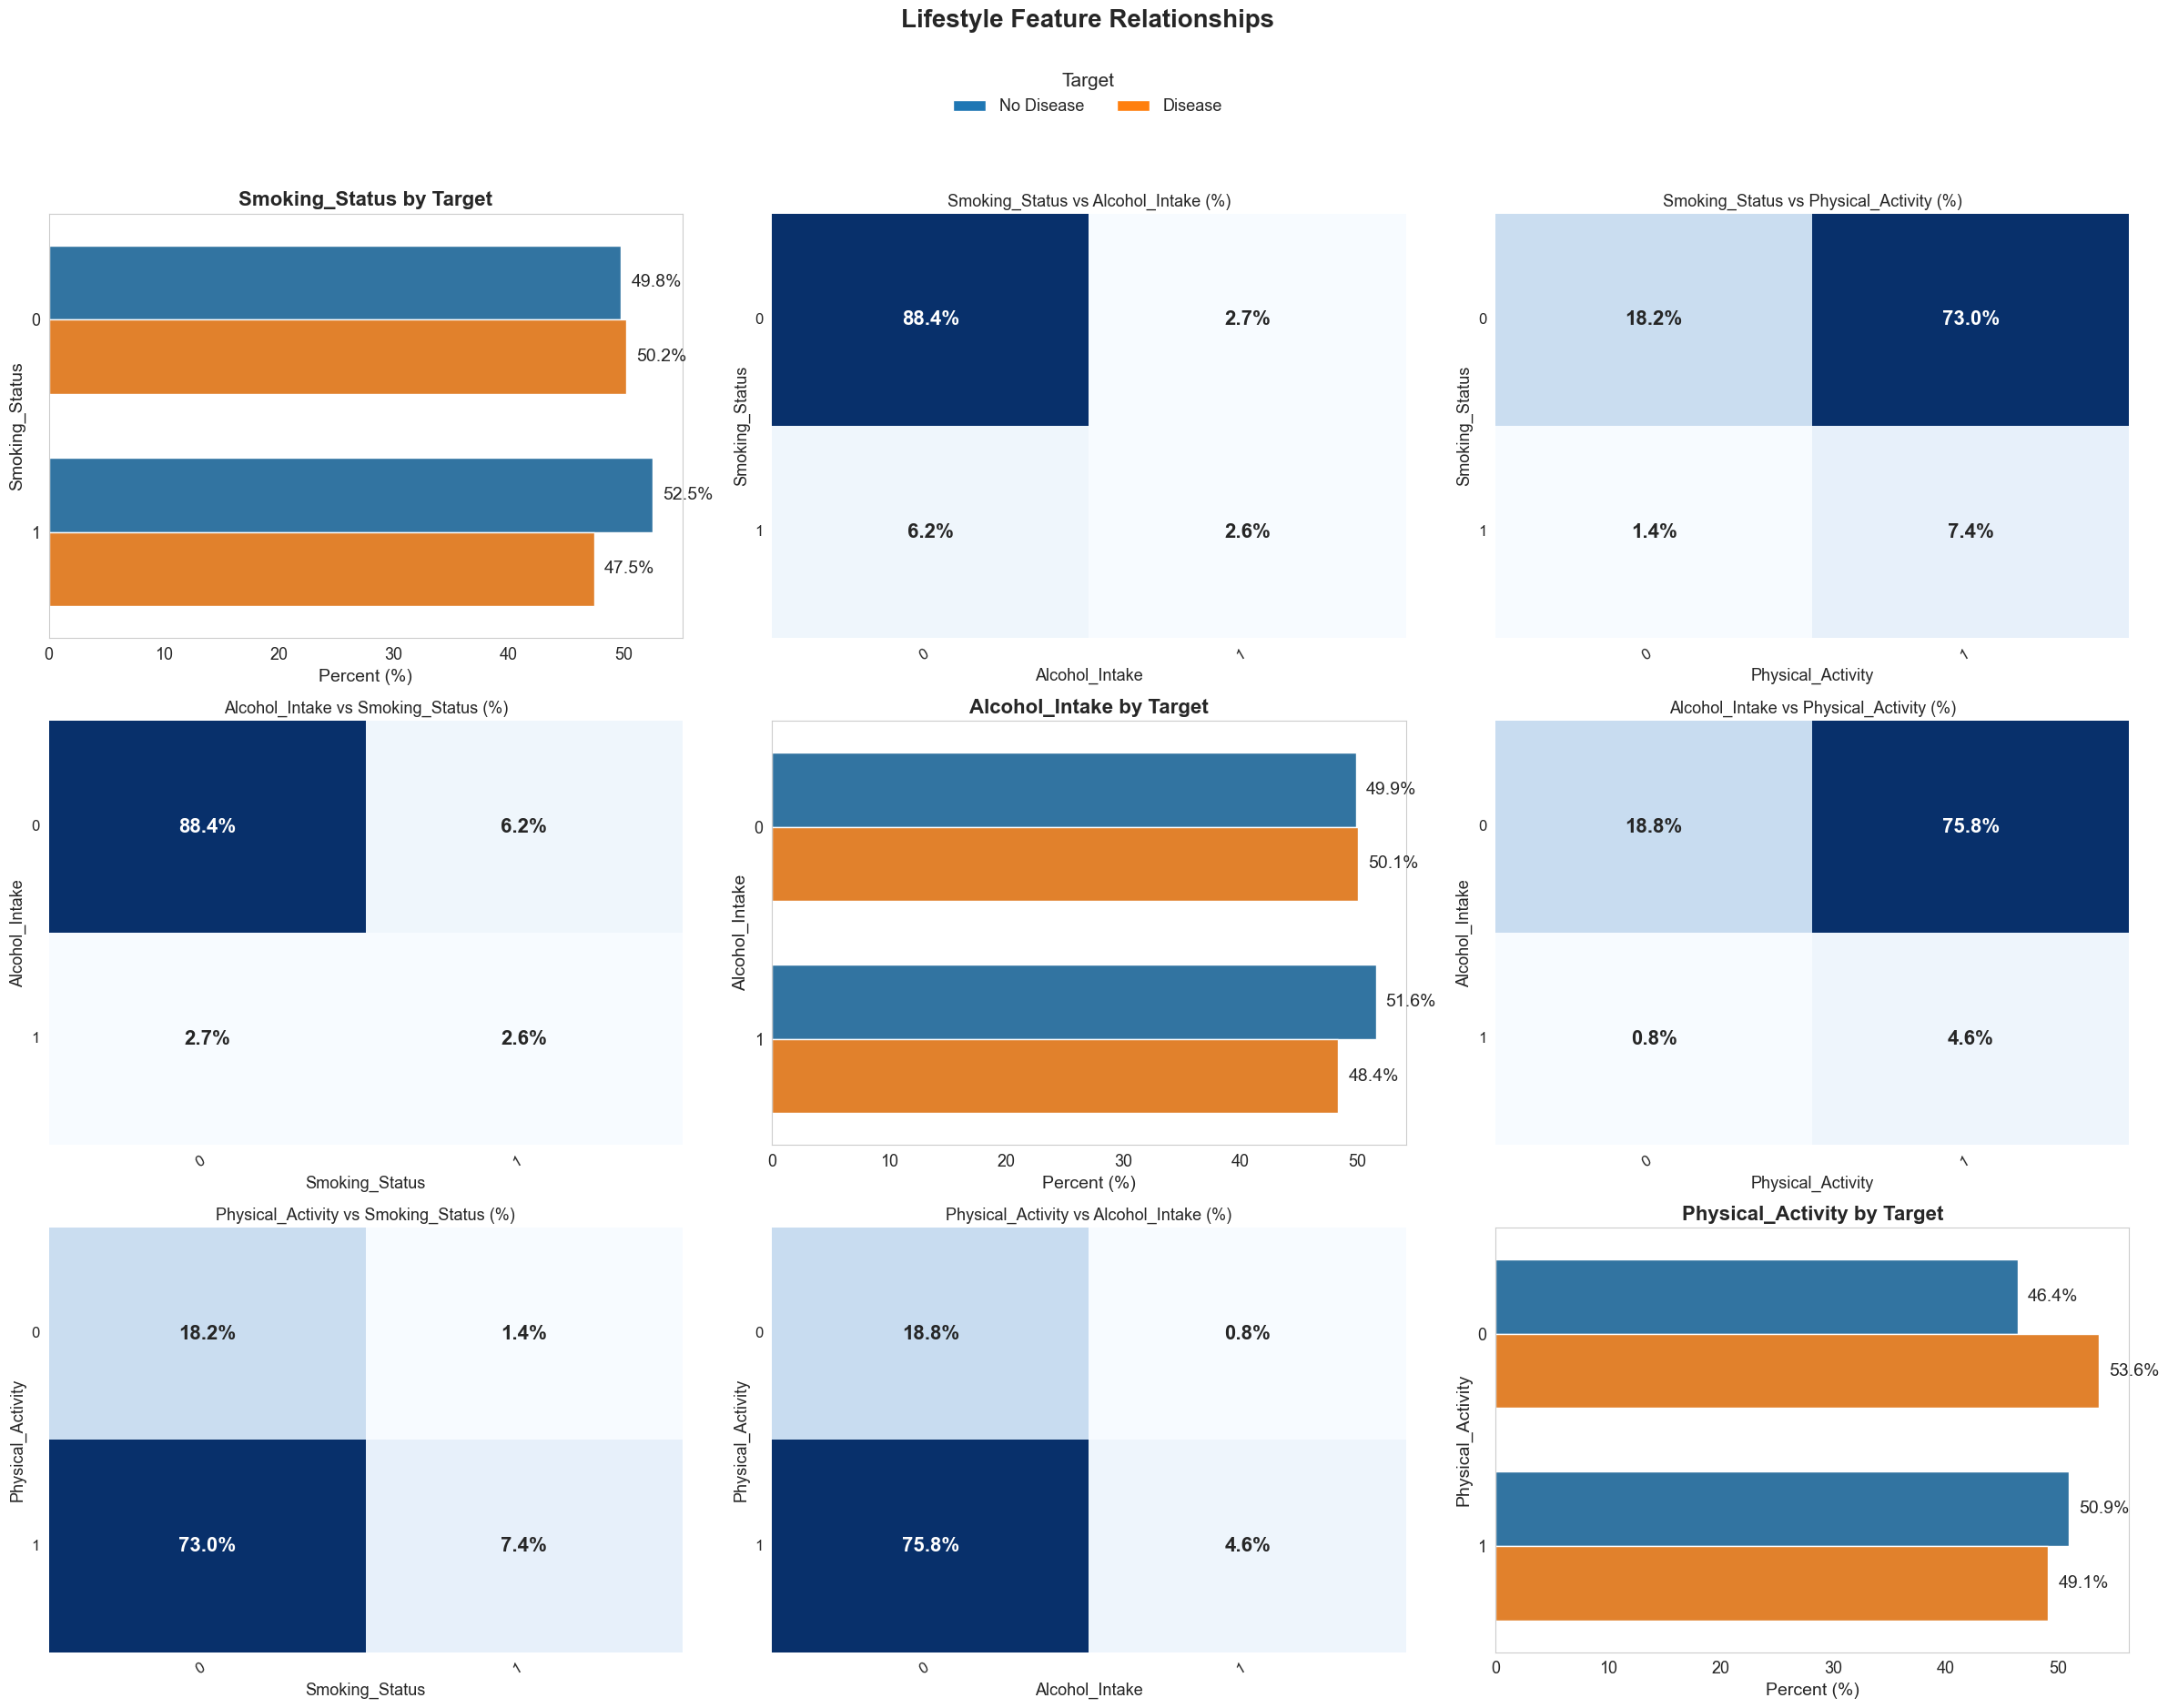

[SUCCESS] Plot saved (overwritten if existed) to: P:\projects\heart disease prediction\reports\visualizations\univariate analysis\categorical analysis\03_Lifestyle_Feature_Relationships.png


In [26]:
# ---------------------------
# Lifestyle features
# ---------------------------
lifestyle = ['Smoking_Status', 'Alcohol_Intake', 'Physical_Activity']

# ---------------------------
# Ensure target_name exists
# ---------------------------
if 'target_name' not in df.columns and 'target' in df.columns:
    df['target_name'] = df['target'].map({0: 'No Disease', 1: 'Disease'})

TARGET_PALETTE = {'No Disease': '#1f77b4', 'Disease': '#ff7f0e'}
target_labels = list(TARGET_PALETTE.keys())
n = len(lifestyle)

# ---------------------------
# Directory to save plots
# ---------------------------
PLOT_DIR = PROJECT_ROOT / 'reports' / 'visualizations' / 'univariate analysis' / 'categorical analysis'
PLOT_DIR.mkdir(parents=True, exist_ok=True)

# ---------------------------
# Figure layout
# ---------------------------
fig, axes = plt.subplots(n, n, figsize=(8*n, 6*n), squeeze=False)

# ---------------------------
# Plotting
# ---------------------------
for i, row_feat in enumerate(lifestyle):
    for j, col_feat in enumerate(lifestyle):
        ax = axes[i, j]
        if i == j:
            # Diagonal: Grouped barplot by target (% labels)
            ct = pd.crosstab(df[row_feat], df['target_name'])
            ct = ct.loc[ct.sum(axis=1) > 0]  # remove empty rows
            ct_pct = ct.div(ct.sum(axis=1), axis=0) * 100
            ct_pct = ct_pct.reset_index().melt(id_vars=row_feat, var_name='target_name', value_name='percent')

            sns.barplot(
                data=ct_pct, y=row_feat, x='percent', hue='target_name',
                palette=TARGET_PALETTE, ax=ax, dodge=True, width=0.7, orient='h', legend=False
            )
            for c in ax.containers:
                ax.bar_label(c, fmt='%.1f%%', fontsize=14, padding=8, label_type='edge')

            ax.set_ylabel(row_feat, fontsize=14)
            ax.set_xlabel('Percent (%)', fontsize=14)
            ax.set_title(f'{row_feat} by Target', fontsize=16, weight='bold')
            ax.grid(False)
            ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha='right', fontsize=13)
            ax.set_xticklabels(ax.get_xticklabels(), fontsize=13)

        else:
            # Off-diagonal: Heatmap of joint distribution (% of total)
            ct = pd.crosstab(df[row_feat], df[col_feat])
            ct = ct.loc[ct.sum(axis=1) > 0, ct.sum(axis=0) > 0]
            if ct.shape[0] > 0 and ct.shape[1] > 0:
                ct_pct = ct / ct.values.sum() * 100
                hm = sns.heatmap(
                    ct_pct, annot=True, fmt='.1f', cmap='Blues', cbar=False, ax=ax,
                    annot_kws={"fontsize": 16, "fontweight": "bold"}
                )
                for text in hm.texts:
                    text.set_text(f"{text.get_text()}%")
                ax.set_xlabel(col_feat, fontsize=13)
                ax.set_ylabel(row_feat, fontsize=13)
                ax.set_title(f'{row_feat} vs {col_feat} (%)', fontsize=13)
                ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right', fontsize=12)
                ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=12)
            else:
                ax.axis('off')

# ---------------------------
# Main title and legend
# ---------------------------
fig.suptitle('Lifestyle Feature Relationships', fontsize=20, weight='bold', y=1.04)
handles = [Patch(facecolor=TARGET_PALETTE[name], label=name) for name in target_labels]
fig.legend(
    handles=handles, labels=target_labels, title='Target', title_fontsize=15, fontsize=13,
    loc='upper center', bbox_to_anchor=(0.5, 1.01), ncol=len(target_labels), frameon=False
)

plt.tight_layout(rect=(0, 0, 1, 0.96))

# ---------------------------
# Save figure robustly (overwrite if exists)
# ---------------------------
img_path = PLOT_DIR / '03_Lifestyle_Feature_Relationships.png'
try:
    if img_path.exists():
        img_path.unlink()  # remove old file
    plt.savefig(img_path, bbox_inches='tight', dpi=150)
    plt.show() 
    print(f"[SUCCESS] Plot saved (overwritten if existed) to: {img_path.resolve()}")
except Exception as e:
    print(f"[ERROR] Could not save plot: {e}")

# ---------------------------
# Cleanup
# ---------------------------
df.drop(['target_name'], axis=1, inplace=True, errors='ignore')

#### **1. Smoking Status**
* **Disease Risk:** Smoking status **doesn't seem to matter** for disease risk. The chances are about 50/50 for both groups.
* **Population Habits:** The heatmaps show that the vast majority of people are non-smokers. The most common profile is a **non-smoker who is physically active (73%)**.

#### **2. Alcohol Intake**
* **Disease Risk:** Similar to smoking, alcohol intake shows **no real link** to the disease. The risk is about 50/50 whether a person drinks or not.
* **Population Habits:** The heatmaps reveal that most people are non-drinkers. In fact, nearly 9 out of 10 people (**88.5%**) are in the same **non-smoking, non-drinking** category.

#### **3. Physical Activity**
* **Disease Risk:** This is the only factor that makes a small difference. One activity group (likely the less active one) has a **slightly higher disease risk (54%)** than the other (49%).
* **Population Habits:** The heatmaps show that the most common person in this dataset is **physically active**, with over 75% of non-drinkers also being physically active.

In [27]:
# Ensure correct columns exist and are not mislabelled
expected_lifestyle = ['Smoking_Status', 'Alcohol_Intake', 'Physical_Activity']
for col in expected_lifestyle:
    if col not in df.columns:
        raise ValueError(f"Column '{col}' not found in DataFrame. Check column names and feature engineering steps.")

# Ensure correct dtype for each lifestyle variable
for col in expected_lifestyle:
    if not pd.api.types.is_categorical_dtype(df[col]):
        df[col] = df[col].astype('category')

lifestyle = ['Smoking_Status', 'Alcohol_Intake', 'Physical_Activity']
target_col = 'target'

results = []
for col in lifestyle:
    ct = pd.crosstab(df[col], df[target_col])
    if ct.empty:
        print(f"Skipping '{col}' due to no data, resulting in an empty crosstab.")
        continue
    chi2, p, dof, expected = chi2_contingency(ct)
    n = ct.values.sum()
    phi2 = chi2 / n
    r, k = ct.shape
    cramers_v = (phi2 / min(k - 1, r - 1)) ** 0.5 if min(k - 1, r - 1) > 0 else 0
    # Direction: difference in disease rate between highest and lowest category
    rates = ct.div(ct.sum(axis=1), axis=0)[1] if 1 in ct.columns else None
    direction = None
    if rates is not None and len(rates) > 1:
        if not (pd.isna(rates.iloc[0]) or pd.isna(rates.iloc[-1])):
            if rates.iloc[-1] > rates.iloc[0]:
                direction = "positive"
            elif rates.iloc[-1] < rates.iloc[0]:
                direction = "negative"
            else:
                direction = "equal"
    results.append({
        "Feature": col,
        "Chi2_p": p,
        "CramersV": cramers_v,
        "Direction": direction
    })

results_df = pd.DataFrame(results)
results_df = results_df[["Feature", "Chi2_p", "CramersV", "Direction"]]
display(results_df)

,Feature,Chi2_p,CramersV,Direction
0,Smoking_Status,4.419530e-05,0.015484,negative
1,Alcohol_Intake,4.930971e-02,0.007453,negative
2,Physical_Activity,2.290904e-21,0.035981,negative


### ***Observations:***

*  ***Physical Activity: A Very Weak Connection ***
    Of these three factors, **Physical Activity** has the strongest link, but it's still **very weak** overall. The data shows that people who are physically active have a slightly lower rate of disease (**49.1%**) compared to those who are not (**53.6%**).

*  **Smoking Status: An Extremely Weak Connection**
    Smoking shows a statistically significant but **practically tiny** relationship with the disease. The difference in disease rates between the two smoking groups is almost negligible (**50.2%** vs. **47.5%**).

* ***Alcohol Intake: No Significant Connection ***
    According to the statistics, **alcohol intake has no significant link** to the disease. The small difference seen in the chart is not statistically meaningful and is likely due to random chance.

### Multivariate Analysis

In [28]:
# Drop unwanted columns with errors='ignore' for robustness
df = df.drop(['Age_Group', 'BMI_Category','BP_label','BP_LEVEL' ], axis=1, errors='ignore')

In [29]:
# --- Configuration ---
from sklearn.pipeline import Pipeline
N_SPLITS_CV = 5
RANDOM_STATE = 42

# ==============================================================================
# 2. DATA PREPARATION & ADVANCED PREPROCESSING
# ==============================================================================
X = df.drop(columns=['target'])
y = df['target']

# --- Define feature groups by their required encoding type ---
NUMERIC_FEATURES = ['Age_Years', 'BMI', 'Pulse_Pressure', 'Systolic_BP', 'Diastolic_BP']
ORDINAL_FEATURES = ['Cholesterol_Level', 'Glucose_Level', 'Smoking_Status',
    'Alcohol_Intake', 'Physical_Activity']
NOMINAL_FEATURES = ['Sex']

# --- Define the specific order for the ordinal features ---
ORDINAL_CATEGORIES = [
    ['Normal', 'Above Normal', 'Well Above Normal'],  # Cholesterol_Level
    ['Normal', 'Above Normal', 'Well Above Normal'],  # Glucose_Level
    [0, 1],                                           # Smoking_Status
    [0, 1],                                           # Alcohol_Intake
    [0, 1],                                           # Physical_Activity
]

# --- Create the complete preprocessing pipeline ---
preprocessor = ColumnTransformer(
    transformers=[
        ('numeric_scaler', StandardScaler(), NUMERIC_FEATURES),
        ('ordinal_encoder', OrdinalEncoder(categories=ORDINAL_CATEGORIES), ORDINAL_FEATURES),
        ('nominal_encoder', OneHotEncoder(handle_unknown='ignore', drop='if_binary'), NOMINAL_FEATURES)
    ],
    remainder='drop'
)

# --- Split data ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

# ==============================================================================
# 3. EARLY STOPPING FUNCTION FOR CV
# ==============================================================================
def early_stopping_cv(pipeline, X, y, n_splits=5, patience=5, min_delta=1e-4, random_state=42):
    """
    Early stopping cross-validation for scikit-learn pipelines.
    Stops if validation ROC AUC does not improve by min_delta for 'patience' rounds.
    Returns the best average ROC AUC and the best fold index.
    """
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    best_score = -np.inf
    best_fold = -1
    no_improve = 0
    scores = []
    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
        y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]
        pipeline.fit(X_train_fold, y_train_fold)
        y_pred_proba = pipeline.predict_proba(X_val_fold)[:, 1]
        score = roc_auc_score(y_val_fold, y_pred_proba)
        scores.append(score)
        if score > best_score + min_delta:
            best_score = score
            best_fold = fold
            no_improve = 0
        else:
            no_improve += 1
        if no_improve >= patience:
            print(f"Early stopping at fold {fold+1} (no improvement in {patience} rounds).")
            break
    return np.mean(scores), best_fold

# ==============================================================================
# 4. MODEL TRAINING WITH EARLY STOPPING CV
# ==============================================================================
# Set up logistic regression classifier without any balancing
penalty = 'l2'
C = 0.01

classifier = LogisticRegression(
    solver='saga', penalty=penalty, C=C, max_iter=1000, random_state=RANDOM_STATE
)

# Create pipeline without balancer step
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', classifier)
])

mean_auc, best_fold = early_stopping_cv(
    pipeline, X_train, y_train, n_splits=N_SPLITS_CV, patience=3, min_delta=1e-4, random_state=RANDOM_STATE
)
print(f"Mean ROC AUC (CV): {mean_auc:.4f} | Best Fold: {best_fold}")

# ==============================================================================
# 5. FINAL MODEL TRAINING AND COEFFICIENTS
# ==============================================================================
pipeline.fit(X_train, y_train)
final_model = pipeline.named_steps['classifier']
feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()
coefficients = pd.Series(final_model.coef_[0], index=feature_names)
model_wt = pd.DataFrame({
    'Feature': coefficients.index,
    'Coefficient': coefficients.values
}).sort_values(by='Coefficient', key=abs, ascending=False)

print("\n--- Final Model Feature Importance (Coefficients) ---")
print(model_wt.to_string(index=False))

Early stopping at fold 4 (no improvement in 3 rounds).
Mean ROC AUC (CV): 0.7923 | Best Fold: 0

--- Final Model Feature Importance (Coefficients) ---
                           Feature  Coefficient
ordinal_encoder__Cholesterol_Level     0.478959
       numeric_scaler__Systolic_BP     0.452371
      numeric_scaler__Diastolic_BP     0.390919
         numeric_scaler__Age_Years     0.340386
    numeric_scaler__Pulse_Pressure     0.332953
ordinal_encoder__Physical_Activity    -0.206083
   ordinal_encoder__Alcohol_Intake    -0.153881
               numeric_scaler__BMI     0.142417
   ordinal_encoder__Smoking_Status    -0.129904
    ordinal_encoder__Glucose_Level    -0.103890
            nominal_encoder__Sex_2     0.029176


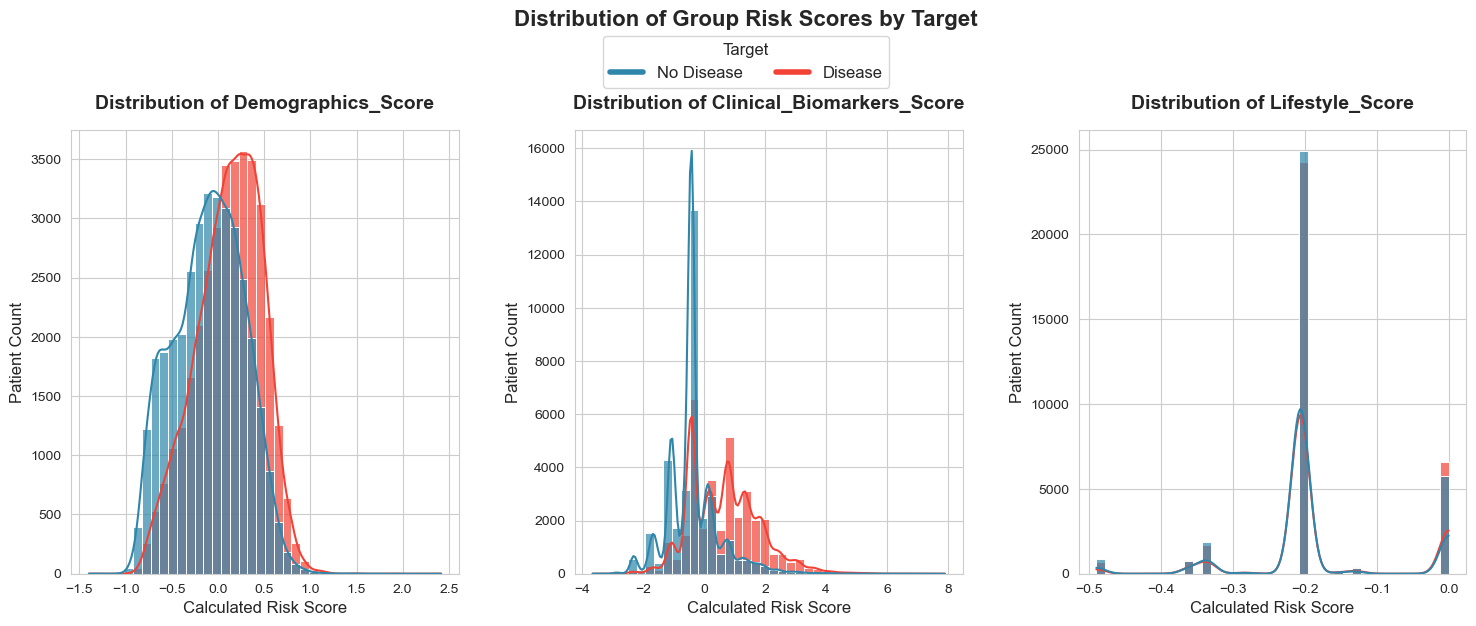

[SUCCESS] Plot saved to: P:\projects\heart disease prediction\reports\visualizations\multivariate analysis\01_Groups_Scores_Distributions.png


In [30]:
target_column = 'target'
scored_df = df.copy()

# ---------------------------
# Groups and features
# ---------------------------
groups_by_original_features = {
    'Demographics_Score': ['Age_Years', 'Sex', 'BMI'],
    'Clinical_Biomarkers_Score': ['Cholesterol_Level', 'Glucose_Level', 'Systolic_BP', 'Diastolic_BP', 'Pulse_Pressure'],
    'Lifestyle_Score': ['Smoking_Status', 'Alcohol_Intake', 'Physical_Activity']
}

# ---------------------------
# Preprocess data
# ---------------------------
X = df.drop(columns=[target_column])
# Use the fitted preprocessor from the pipeline
fitted_preprocessor = pipeline.named_steps['preprocessor']
X_transformed = fitted_preprocessor.transform(X)

# Convert sparse to dense if needed
if hasattr(X_transformed, "toarray"):
    df_transformed = pd.DataFrame(
        X_transformed.toarray(),
        columns=fitted_preprocessor.get_feature_names_out(),
        index=df.index
    )
else:
    df_transformed = pd.DataFrame(
        X_transformed,
        columns=fitted_preprocessor.get_feature_names_out(),
        index=df.index
    )

# ---------------------------
# Compute scores
# ---------------------------
for group_name, original_features_list in groups_by_original_features.items():
    # Select transformed features for this group
    group_cols = [c for c in df_transformed.columns if any(orig in c for orig in original_features_list)]
    # Keep only features present in coefficients
    group_cols = [c for c in group_cols if c in coefficients.index]
    
    if group_cols:
        scored_df[group_name] = df_transformed[group_cols].dot(coefficients[group_cols])
    else:
        scored_df[group_name] = 0.0

# ---------------------------
# Convert target to string for plotting
# ---------------------------
scored_df[target_column] = scored_df[target_column].map({0: 'No Disease', 1: 'Disease'})

# ---------------------------
# Plot histograms
# ---------------------------
score_columns = list(groups_by_original_features.keys())
palette = {'No Disease': '#2E86AB', 'Disease': '#F24236'}

fig, axes = plt.subplots(1, len(score_columns), figsize=(6 * len(score_columns), 6), sharey=False)
if len(score_columns) == 1:
    axes = [axes]

for i, score_col in enumerate(score_columns):
    ax = axes[i]
    sns.histplot(
        data=scored_df,
        x=score_col,
        hue=target_column,
        bins=40,
        palette=palette,
        kde=True,
        alpha=0.7,
        ax=ax
    )
    ax.set_title(f'Distribution of {score_col}', fontsize=14, fontweight='bold', pad=15)
    ax.set_xlabel('Calculated Risk Score', fontsize=12)
    ax.set_ylabel('Patient Count', fontsize=12)
    if ax.get_legend() is not None:
        ax.get_legend().remove()

# ---------------------------
# Title + Shared Legend
# ---------------------------
fig.suptitle('Distribution of Group Risk Scores by Target', fontsize=16, fontweight='bold', y=1.05)

handles = [Line2D([0], [0], color=c, lw=4) for c in palette.values()]
labels = list(palette.keys())
fig.legend(handles, labels, title='Target', loc='upper center', ncol=2, frameon=True, fontsize=12, title_fontsize=12, bbox_to_anchor=(0.5, 1.02))

# Adjust layout
fig.subplots_adjust(top=0.85, wspace=0.3)

# ---------------------------
# Save figure robustly
# ---------------------------
PLOT_DIR = PROJECT_ROOT / 'reports' / 'visualizations' / 'multivariate analysis'
PLOT_DIR.mkdir(parents=True, exist_ok=True)

img_path = PLOT_DIR / '01_Groups_Scores_Distributions.png'
if img_path.exists():
    img_path.unlink()

plt.savefig(img_path, bbox_inches='tight', dpi=150)
plt.show()
print(f"[SUCCESS] Plot saved to: {img_path.resolve()}")

* **`Clinical_Biomarkers_Score` (Primary Driver)**
    This score, composed of cardiovascular and metabolic indicators (BP, Cholesterol, Glucose), is the **strongest predictor** of the target. Higher scores are clearly associated with the "Disease" group, confirming that these vitals are the dominant drivers of the model.

* **`DemographicsScore` (Secondary Driver)**
    This score, combining Age, BMI, and Sex, is a **secondary contributor** to the overall risk. It shows a moderate positive correlation with the "Disease" group but is less influential than the Vitals score.

* **`Lifestyle_Score` (Confounding Factor)**
    This score shows a **counter-intuitive relationship** where lower (more protective) lifestyle scores are associated with the "Disease" group. This indicates a confounding effect: the at-risk population in this dataset has healthier lifestyle habits that are being overpowered by the significant negative impact of their poor vitals.

[INFO] Using existing folder: P:\projects\heart disease prediction\reports\visualizations\multivariate analysis


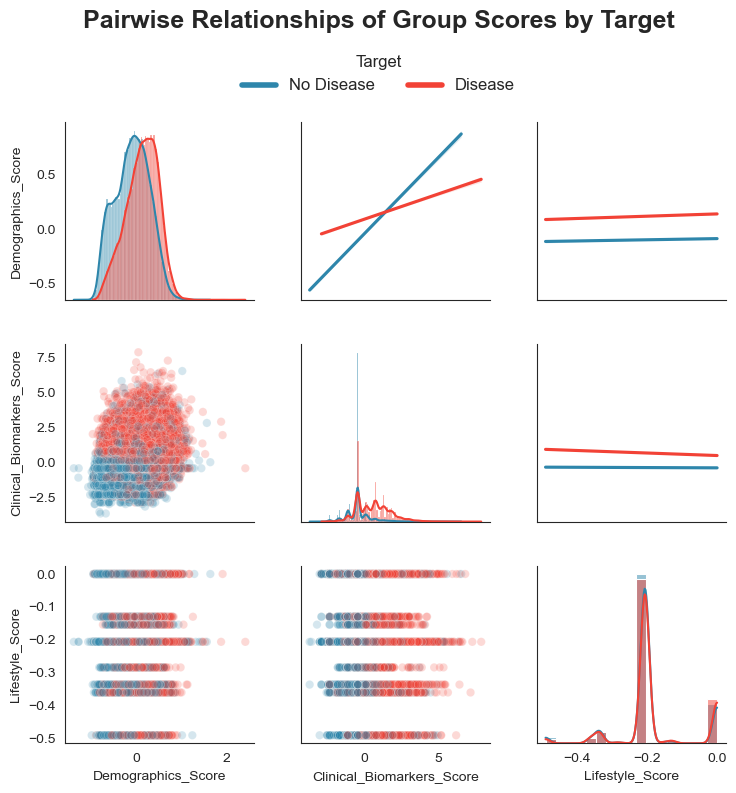

[SUCCESS] Plot saved at: P:\projects\heart disease prediction\reports\visualizations\multivariate analysis\02_Pairwise_Group_Score_Relationships.png

Correlation between scores and target:
Demographics_Score: Pearson=0.284, Spearman=0.281
Clinical_Biomarkers_Score: Pearson=0.456, Spearman=0.476
Lifestyle_Score: Pearson=0.037, Spearman=0.035


In [31]:
# ==============================================================================
# Pairwise Group Score Relationships + Correlations
# ==============================================================================
# --- 1. Prepare Data ---
score_cols = ['Demographics_Score', 'Clinical_Biomarkers_Score', 'Lifestyle_Score']
target_col = 'target'

# Drop rows with missing scores or target to avoid empty plots
plot_df = scored_df.dropna(subset=score_cols + [target_col]).copy()

# Ensure target is numeric for plotting
if plot_df[target_col].dtype == object or str(plot_df[target_col].dtype).startswith('category'):
    plot_df['target_bin'] = plot_df[target_col].map({'No Disease': 0, 'Disease': 1})
else:
    plot_df['target_bin'] = plot_df[target_col]

# --- 2. PairGrid for Scores ---
sns.set_style("white")

PAIRGRID_PALETTE = {0: "#2E86AB", 1: "#F24236"}
g = sns.PairGrid(
    plot_df,
    vars=score_cols,
    hue='target_bin',
    palette=PAIRGRID_PALETTE,
    diag_sharey=False
)
g.map_lower(sns.scatterplot, alpha=0.2)
g.map_diag(lambda x, color, **kwargs: sns.histplot(x, color=color, kde=True, **kwargs))
g.map_upper(lambda x, y, color, **kwargs: sns.regplot(x=x, y=y, scatter=False, line_kws={'color': color}, **kwargs))

# --- 3. Title and Legend positioning ---
g.fig.suptitle(
    'Pairwise Relationships of Group Scores by Target',
    fontsize=18, fontweight='bold', y=1.05
)

handles = [Line2D([0], [0], color=c, lw=4) for c in PAIRGRID_PALETTE.values()]
labels = ['No Disease', 'Disease']
g.fig.legend(
    handles=handles,
    labels=labels,
    title='Target',
    loc='upper center',
    bbox_to_anchor=(0.5, 1.01),
    ncol=len(labels),
    frameon=False,
    fontsize=12,
    title_fontsize=12
)

# Adjust subplot spacing so title & legend don't overlap
g.fig.subplots_adjust(top=0.90, hspace=0.25, wspace=0.25)

# --- 4. Save figure ---
# Use absolute path to existing reports folder outside src
PLOT_DIR = Path.cwd().parent.parent / 'reports' / 'visualizations' / 'multivariate analysis'

# Do not create folder if it exists
if PLOT_DIR.is_dir():
    print(f"[INFO] Using existing folder: {PLOT_DIR.resolve()}")
else:
    PLOT_DIR.mkdir(parents=True, exist_ok=True)
    print(f"[INFO] Created folder: {PLOT_DIR.resolve()}")

img_path = PLOT_DIR / '02_Pairwise_Group_Score_Relationships.png'

# Overwrite image if it exists
plt.savefig(img_path, bbox_inches='tight', dpi=150)
plt.show()
print(f"[SUCCESS] Plot saved at: {img_path.resolve()}")

# --- 5. Check Linearity (Pearson & Spearman correlations) ---
print("\nCorrelation between scores and target:")
for col in score_cols:
    temp_df = plot_df[[col, 'target_bin']].dropna()
    if len(temp_df) > 1:
        pearson = pearsonr(temp_df[col], temp_df['target_bin'])[0]
        spearman = spearmanr(temp_df[col], temp_df['target_bin'])[0]
        print(f"{col}: Pearson={pearson:.3f}, Spearman={spearman:.3f}")
    else:
        print(f"{col}: Not enough data to calculate correlation.")

# Cleanup
del plot_df['target_bin']

### risk score creation

In [33]:
# ----------------------------
# Setup
# ----------------------------
from matplotlib.patches import Patch

warnings.filterwarnings("ignore")
optuna.logging.set_verbosity(optuna.logging.WARNING)

# ----------------------------
# 1. Ensure target_label exists
# ----------------------------
if 'target_label' not in scored_df.columns:
    target_mapping = {0: 'No Disease', 1: 'Disease'}
    if scored_df['target'].dtype == object or str(scored_df['target'].dtype).startswith('category'):
        scored_df['target_label'] = scored_df['target']
    else:
        scored_df['target_label'] = scored_df['target'].map(target_mapping)

# ----------------------------
# 2. Prepare features and target
# ----------------------------
score_cols = ['Demographics_Score', 'Clinical_Biomarkers_Score', 'Lifestyle_Score']
X = scored_df[score_cols].copy()
y = scored_df['target_label'].map({'No Disease': 0, 'Disease': 1}).copy()

# ----------------------------
# 3. Train/test split
# ----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ----------------------------
# 4. Define balancers
# ----------------------------
balancers = {
    "SMOTE": SMOTE(random_state=42),
    "RandomOverSampler": RandomOverSampler(random_state=42),
}

# ----------------------------
# 5. XGBoost Optuna objective
# ----------------------------
def xgb_objective(trial):
    balancer_name = trial.suggest_categorical("balancer", list(balancers.keys()))
    balancer = balancers[balancer_name]
    X_res, y_res = balancer.fit_resample(X_train, y_train)
    xgb = XGBClassifier(
        use_label_encoder=False,
        eval_metric='auc',
        random_state=42,
        max_depth=2,
        min_child_weight=20,
        subsample=0.5,
        colsample_bytree=0.5,
        reg_alpha=50.0,
        reg_lambda=200.0,
        gamma=10.0,
        n_estimators=60,
        learning_rate=0.01
    )
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    aucs = []
    for train_idx, valid_idx in skf.split(X_res, y_res):
        X_tr, X_val = X_res.iloc[train_idx], X_res.iloc[valid_idx]
        y_tr, y_val = y_res.iloc[train_idx], y_res.iloc[valid_idx]
        xgb.fit(X_tr, y_tr, verbose=False)
        y_pred = xgb.predict_proba(X_val)[:, 1]
        aucs.append(roc_auc_score(y_val, y_pred))
    return float(np.mean(aucs))

xgb_study = optuna.create_study(direction="maximize")
xgb_study.optimize(xgb_objective, n_trials=10, show_progress_bar=False)

print(f"\n[XGBoost] Best balancer: {xgb_study.best_trial.params['balancer']}")
print(f"[XGBoost] Best mean CV ROC AUC: {xgb_study.best_trial.value:.4f}")

# ----------------------------
# 6. Retrain XGBoost final model
# ----------------------------
best_balancer_xgb = balancers[xgb_study.best_trial.params['balancer']]
X_train_bal_xgb, y_train_bal_xgb = best_balancer_xgb.fit_resample(X_train, y_train)

final_xgb = XGBClassifier(
    use_label_encoder=False,
    eval_metric='auc',
    random_state=42,
    max_depth=2,
    min_child_weight=20,
    subsample=0.5,
    colsample_bytree=0.5,
    reg_alpha=50.0,
    reg_lambda=200.0,
    gamma=10.0,
    n_estimators=60,
    learning_rate=0.01
)
final_xgb.fit(X_train_bal_xgb, y_train_bal_xgb)

scored_df['Unified_Score_XGB'] = final_xgb.predict_proba(X)[:, 1]
auc_xgb = roc_auc_score(y, scored_df['Unified_Score_XGB'])
print(f"[XGBoost] Unified Score ROC AUC on full data: {auc_xgb:.3f}")

# ----------------------------
# 7. Plot Unified Risk Score Distribution
# ----------------------------
fig, ax = plt.subplots(figsize=(10, 6))

sns.histplot(
    data=scored_df,
    x='Unified_Score_XGB',
    hue='target_label',
    bins=15,
    palette={'No Disease': '#2E86AB', 'Disease': '#F24236'},
    kde=False,
    stat="probability",
    multiple="fill",
    alpha=0.8,
    legend=False,
    ax=ax
)

fig.suptitle(
    'Proportion of Each Target by Unified Risk Score (XGBoost)',
    fontsize=16,
    fontweight='bold',
    y=0.98
)

legend_handles = [
    Patch(facecolor='#2E86AB', label='No Disease'),
    Patch(facecolor='#F24236', label='Disease')
]

fig.legend(
    handles=legend_handles,
    title='Target',
    loc='upper center',
    bbox_to_anchor=(0.5, 0.91),
    ncol=2,
    frameon=False,
    fontsize=12,
    title_fontsize=13
)

ax.set_xlabel('Unified Risk Score (Probability)', fontsize=12)
ax.set_ylabel('Proportion', fontsize=12)

plt.tight_layout(rect=[0, 0, 1, 0.85])
ax.grid(False)  # remove gridlines

# ----------------------------
# 8. Save outside src
# ----------------------------
OUTSIDE_DIR = PROJECT_ROOT.parent / 'reports' / 'visualizations' / 'multivariate_analysis'
OUTSIDE_DIR.mkdir(parents=True, exist_ok=True)

img_path = OUTSIDE_DIR / '03_CHDRI_Score_Distribution.png'
if img_path.exists():
    img_path.unlink()

plt.savefig(img_path, bbox_inches='tight', dpi=150)
print(f"[SAVED] Plot stored at: {img_path.resolve()}")
plt.show()

NameError: name 'scored_df' is not defined

### Quantile binning - Risk group creation

[INFO] Saving plots into existing directory: P:\projects\heart disease prediction\reports\visualizations\multivariate analysis


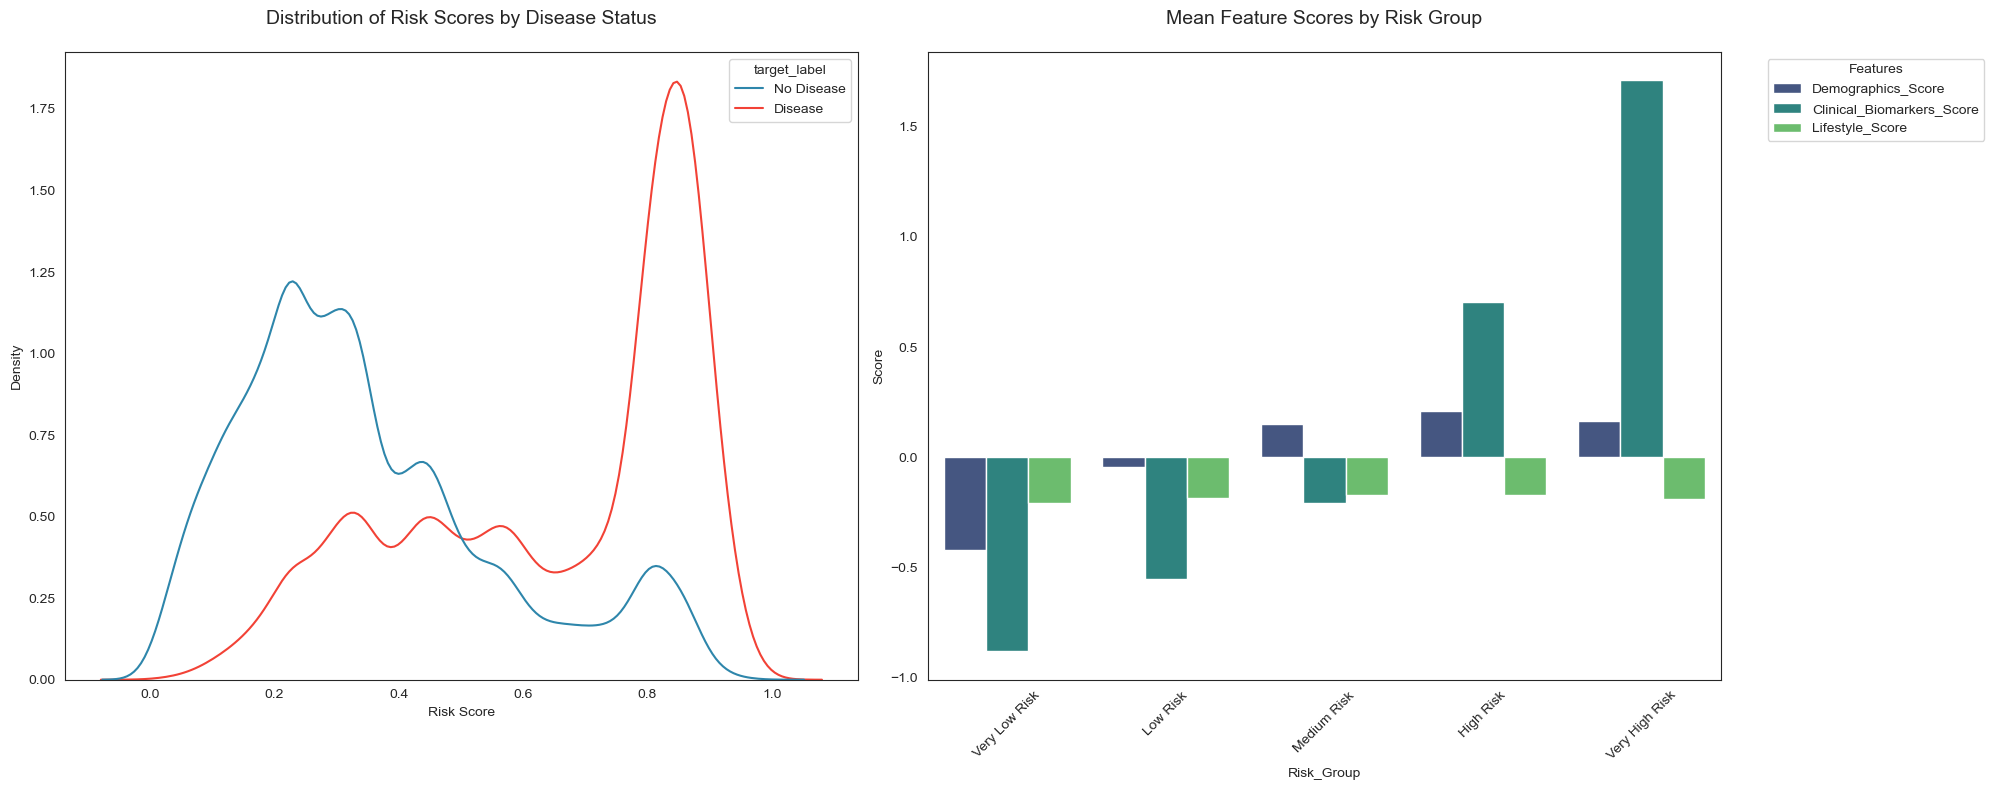


Risk Group Distribution:
target_label    No Disease  Disease
Risk_Group                         
Very Low Risk         85.8     14.2
Low Risk              70.6     29.4
Medium Risk           54.2     45.8
High Risk             28.2     71.8
Very High Risk        10.7     89.3

Feature Importance:
                     Feature  Importance
1  Clinical_Biomarkers_Score    0.763583
0         Demographics_Score    0.130943
2            Lifestyle_Score    0.105474


In [33]:
# ------------------------ 2. CONFIGURATION ---------------------------------
RANDOM_STATE = 42
N_SPLITS_CV = 5
N_TRIALS = 50
N_JOBS = -1

# ------------------------ 3. PROJECT ROOT & PLOT DIRECTORY -----------------
CURRENT_DIR = Path.cwd()
PROJECT_ROOT = CURRENT_DIR
while 'src' in [p.name.lower() for p in PROJECT_ROOT.parents] or PROJECT_ROOT.name.lower() == 'src':
    PROJECT_ROOT = PROJECT_ROOT.parent

PLOT_DIR = PROJECT_ROOT / 'reports' / 'visualizations' / 'multivariate analysis'
print(f"[INFO] Saving plots into existing directory: {PLOT_DIR.resolve()}")

# ------------------------ 4. DATA PREPARATION --------------------------------
target_column = 'target'
target_mapping = {0: 'No Disease', 1: 'Disease'}
features = ['Demographics_Score', 'Clinical_Biomarkers_Score', 'Lifestyle_Score']

# Drop rows where target is NaN to avoid errors in model training
scored_df = scored_df.dropna(subset=[target_column])

if 'target_label' not in scored_df.columns:
    scored_df['target_label'] = scored_df[target_column].map(target_mapping)

if scored_df[target_column].dtype == object or str(scored_df[target_column].dtype).startswith('category'):
    reverse_mapping = {v: k for k, v in target_mapping.items()}
    scored_df[target_column] = scored_df['target_label'].map(reverse_mapping)

# ------------------------ 5. MODEL TRAINING --------------------------------
X = scored_df[features].copy()
y = scored_df[target_column].copy()

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=RANDOM_STATE, stratify=y
)

# Balance training data using SMOTE
smote = SMOTE(random_state=RANDOM_STATE)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

# Train XGBoost model
model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    use_label_encoder=False,
    random_state=RANDOM_STATE
)
model.fit(X_train_bal, y_train_bal)

# ------------------------ 6. RISK SCORE CALCULATION -------------------------
# Calculate risk scores for all data
all_predictions = model.predict_proba(X)[:, 1]
scored_df['Risk_Score'] = all_predictions

# Create risk groups using quantile binning
risk_labels = ["Very Low Risk", "Low Risk", "Medium Risk", "High Risk", "Very High Risk"]
scored_df['Risk_Group'] = pd.qcut(scored_df['Risk_Score'], 
                                 q=5, 
                                 labels=risk_labels)

# ------------------------ 7. VISUALIZATION ---------------------------------
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Plot 1: Distribution of Risk Scores
sns.kdeplot(
    data=scored_df,
    x='Risk_Score',
    hue='target_label',
    palette={'No Disease': '#2E86AB', 'Disease': '#F24236'},
    ax=axes[0]
)
axes[0].set_title('Distribution of Risk Scores by Disease Status', 
                  fontsize=14, pad=20)
axes[0].set_xlabel('Risk Score')
axes[0].set_ylabel('Density')

# Plot 2: Mean Feature Scores by Risk Group
mean_scores = scored_df.groupby('Risk_Group')[features].mean().reset_index()
mean_scores_melted = mean_scores.melt(
    id_vars='Risk_Group',
    var_name='Feature',
    value_name='Score'
)

sns.barplot(
    data=mean_scores_melted,
    x='Risk_Group',
    y='Score',
    hue='Feature',
    palette='viridis',
    ax=axes[1]
)
axes[1].set_title('Mean Feature Scores by Risk Group', 
                  fontsize=14, pad=20)
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)
axes[1].legend(title='Features', bbox_to_anchor=(1.05, 1))

plt.tight_layout()
plt.savefig(PLOT_DIR / 'Risk_Analysis.png', bbox_inches='tight', dpi=150)
plt.show()

# Print summary statistics
print("\nRisk Group Distribution:")
print(scored_df.groupby('Risk_Group')['target_label']
      .value_counts(normalize=True)
      .unstack()
      .round(3) * 100)

print("\nFeature Importance:")
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': model.feature_importances_
})
print(importance_df.sort_values('Importance', ascending=False))

In [34]:
results_df.columns

Index(['Feature', 'Chi2_p', 'CramersV', 'Direction'], dtype='object')

In [35]:
scored_df.columns

Index(['Age_Years', 'Sex', 'Systolic_BP', 'Diastolic_BP', 'Cholesterol_Level',
       'Glucose_Level', 'Smoking_Status', 'Alcohol_Intake',
       'Physical_Activity', 'target', 'BMI', 'BP_level', 'Pulse_Pressure',
       'Demographics_Score', 'Clinical_Biomarkers_Score', 'Lifestyle_Score',
       'target_label', 'Unified_Score_XGB', 'Risk_Score', 'Risk_Group'],
      dtype='object')

In [36]:
# rename 'Unified_Score_XGB' to 'Unified_Risk_Score'
scored_df = scored_df.rename(columns={'Unified_Score_XGB': 'Unified_Risk_Score'})

In [37]:
# Merge scores from scored_df and prediction columns from results_df into df

# Merge scores from scored_df
df = df.merge(
    scored_df[['Demographics_Score', 'Clinical_Biomarkers_Score', 
               'Lifestyle_Score', 'Unified_Risk_Score']],
    left_index=True, right_index=True, how='left'
)

# Merge Pred_Prob and Pred_Risk_Quantile from results_df (only available for test set indices)
if 'Pred_Prob' in results_df.columns and 'Pred_Risk_Quantile' in results_df.columns:
    # Get only the indices that exist in both DataFrames
    common_indices = results_df.index.intersection(df.index)
    df.loc[common_indices, 'Pred_Prob'] = results_df.loc[common_indices, 'Pred_Prob']
    df.loc[common_indices, 'Pred_Risk_Quantile'] = results_df.loc[common_indices, 'Pred_Risk_Quantile']

df.columns
del scored_df, results_df

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69579 entries, 0 to 69975
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   Age_Years                  69579 non-null  float64 
 1   Sex                        69579 non-null  category
 2   Systolic_BP                69579 non-null  float64 
 3   Diastolic_BP               69579 non-null  float64 
 4   Cholesterol_Level          69579 non-null  category
 5   Glucose_Level              69579 non-null  category
 6   Smoking_Status             69579 non-null  category
 7   Alcohol_Intake             69579 non-null  category
 8   Physical_Activity          69579 non-null  category
 9   target                     69579 non-null  category
 10  BMI                        69579 non-null  float64 
 11  BP_level                   69579 non-null  category
 12  Pulse_Pressure             69579 non-null  float64 
 13  Demographics_Score         6957

In [39]:
# Define DATA_PROCESSED_DIR if not already defined
DATA_PROCESSED_DIR = Path(os.environ.get('DATA_PROCESSED_DIR', PROJECT_ROOT / 'data/processed')).resolve()

# Save the DataFrame with error handling and config path
output_path = DATA_PROCESSED_DIR / "processed_data.parquet"
output_path.parent.mkdir(parents=True, exist_ok=True)
if output_path.exists():
    output_path.unlink()
try:
    df.to_parquet(output_path, index=False)
    file_size_mb = output_path.stat().st_size / (1024 * 1024)
except Exception as e:
    traceback.print_exc()